# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_75109/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_75109/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_75109/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [ ]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 1.0 }, # E[λ]=2
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

  0%|          | 1/1000 [00:01<17:43,  1.06s/it]

[1/1000] train=235.4008  val=236.7752  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:01<12:43,  1.31it/s]

[2/1000] train=228.9634  val=234.5744  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:02<11:32,  1.44it/s]

[3/1000] train=227.0570  val=232.3743  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:02<11:46,  1.41it/s]

[4/1000] train=223.5216  val=230.1758  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:03<11:11,  1.48it/s]

[5/1000] train=222.9206  val=227.9785  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:04<10:20,  1.60it/s]

[6/1000] train=230.8913  val=225.7822  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:04<09:48,  1.69it/s]

[7/1000] train=217.7360  val=223.5871  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:05<08:47,  1.88it/s]

[8/1000] train=220.4435  val=221.3932  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:05<08:07,  2.03it/s]

[9/1000] train=216.8551  val=219.2008  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:05<07:32,  2.19it/s]

[10/1000] train=215.3479  val=217.0097  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:06<06:57,  2.37it/s]

[11/1000] train=219.0493  val=214.8195  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:06<06:37,  2.49it/s]

[12/1000] train=216.3609  val=212.6307  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:06<06:27,  2.55it/s]

[13/1000] train=217.2374  val=210.4431  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:07<06:19,  2.60it/s]

[14/1000] train=220.5232  val=208.2560  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:07<06:32,  2.51it/s]

[15/1000] train=207.6794  val=206.0701  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:07<06:03,  2.71it/s]

[16/1000] train=207.4512  val=203.8853  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:08<05:45,  2.85it/s]

[17/1000] train=200.5153  val=201.7019  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:08<05:25,  3.02it/s]

[18/1000] train=203.9062  val=199.5194  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:08<05:08,  3.18it/s]

[19/1000] train=195.0579  val=197.3380  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:09<05:01,  3.25it/s]

[20/1000] train=201.3489  val=195.1579  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:09<04:58,  3.28it/s]

[21/1000] train=188.1435  val=192.9792  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:09<04:48,  3.39it/s]

[22/1000] train=193.8301  val=190.8018  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:10<04:45,  3.42it/s]

[23/1000] train=184.2744  val=188.6258  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:10<04:43,  3.45it/s]

[24/1000] train=193.3474  val=186.4517  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:10<04:54,  3.31it/s]

[25/1000] train=184.2172  val=184.2781  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:11<05:29,  2.95it/s]

[26/1000] train=180.6003  val=182.1055  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:11<05:43,  2.83it/s]

[27/1000] train=180.3444  val=179.9338  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:11<05:46,  2.81it/s]

[28/1000] train=178.1722  val=177.7631  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:12<05:47,  2.79it/s]

[29/1000] train=171.3831  val=175.5941  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:12<05:49,  2.77it/s]

[30/1000] train=180.1160  val=173.4270  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:13<06:34,  2.45it/s]

[31/1000] train=173.1960  val=171.2611  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:13<06:31,  2.47it/s]

[32/1000] train=172.1508  val=169.0958  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:14<08:40,  1.86it/s]

[33/1000] train=166.9236  val=166.9317  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:17<19:33,  1.21s/it]

[34/1000] train=164.6389  val=164.7694  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:17<15:55,  1.01it/s]

[35/1000] train=164.4569  val=162.6086  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:17<13:11,  1.22it/s]

[36/1000] train=162.3644  val=160.4493  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:18<11:19,  1.42it/s]

[37/1000] train=158.9029  val=158.2914  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:18<10:10,  1.58it/s]

[38/1000] train=151.6435  val=156.1354  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:19<09:36,  1.67it/s]

[39/1000] train=154.2685  val=153.9804  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:19<09:01,  1.77it/s]

[40/1000] train=153.7691  val=151.8264  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:20<10:53,  1.47it/s]

[41/1000] train=154.8550  val=149.6736  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:21<12:33,  1.27it/s]

[42/1000] train=154.7565  val=147.5224  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:22<11:07,  1.43it/s]

[43/1000] train=145.1729  val=145.3727  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:22<10:13,  1.56it/s]

[44/1000] train=138.4967  val=143.2250  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:23<09:09,  1.74it/s]

[45/1000] train=143.3853  val=141.0793  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:23<08:42,  1.83it/s]

[46/1000] train=141.6521  val=138.9353  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:24<08:01,  1.98it/s]

[47/1000] train=137.5149  val=136.7936  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:24<07:18,  2.17it/s]

[48/1000] train=135.8120  val=134.6525  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:24<06:47,  2.34it/s]

[49/1000] train=134.3305  val=132.5122  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:25<06:21,  2.49it/s]

[50/1000] train=132.8725  val=130.3722  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:25<07:16,  2.18it/s]

[51/1000] train=130.9225  val=128.2334  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:26<08:30,  1.86it/s]

[52/1000] train=125.4687  val=126.0959  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:27<09:17,  1.70it/s]

[53/1000] train=124.8282  val=123.9611  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:29<15:24,  1.02it/s]

[54/1000] train=121.8553  val=121.8281  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:29<14:45,  1.07it/s]

[55/1000] train=124.5473  val=119.6974  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:30<14:35,  1.08it/s]

[56/1000] train=114.7505  val=117.5689  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:31<14:50,  1.06it/s]

[57/1000] train=114.2628  val=115.4418  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:33<15:47,  1.01s/it]

[58/1000] train=115.6161  val=113.3161  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:33<14:25,  1.09it/s]

[59/1000] train=113.0207  val=111.1924  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:34<12:58,  1.21it/s]

[60/1000] train=110.3989  val=109.0704  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:34<11:34,  1.35it/s]

[61/1000] train=105.8647  val=106.9503  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:35<11:52,  1.32it/s]

[62/1000] train=105.8538  val=104.8321  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:36<12:21,  1.26it/s]

[63/1000] train=103.7442  val=102.7158  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:37<11:29,  1.36it/s]

[64/1000] train=103.1158  val=100.6014  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:37<10:24,  1.50it/s]

[65/1000] train=101.3653  val=98.4887  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1275  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:38<09:52,  1.58it/s]

[66/1000] train=98.4064  val=96.3778  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:38<09:25,  1.65it/s]

[67/1000] train=96.8341  val=94.2690  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:39<09:14,  1.68it/s]

[68/1000] train=94.4081  val=92.1622  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:39<08:58,  1.73it/s]

[69/1000] train=88.1927  val=90.0575  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:40<08:46,  1.76it/s]

[70/1000] train=88.3698  val=87.9545  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1368


  7%|▋         | 71/1000 [00:40<08:32,  1.81it/s]

[71/1000] train=84.9993  val=85.8534  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:41<08:25,  1.84it/s]

[72/1000] train=84.4330  val=83.7544  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:42<09:27,  1.63it/s]

[73/1000] train=78.5276  val=81.6578  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:43<11:02,  1.40it/s]

[74/1000] train=81.0171  val=79.5645  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:43<11:21,  1.36it/s]

[75/1000] train=77.0304  val=77.4731  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:44<12:23,  1.24it/s]

[76/1000] train=74.7081  val=75.3843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:45<12:56,  1.19it/s]

[77/1000] train=74.2904  val=73.2979  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:46<13:33,  1.13it/s]

[78/1000] train=71.7515  val=71.2125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:47<14:14,  1.08it/s]

[79/1000] train=70.1508  val=69.1275  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:52<29:41,  1.94s/it]

[80/1000] train=69.5325  val=67.0444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:53<28:54,  1.89s/it]

[81/1000] train=63.2970  val=64.9634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:54<24:19,  1.59s/it]

[82/1000] train=63.7979  val=62.8851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:55<21:27,  1.40s/it]

[83/1000] train=62.8183  val=60.8101  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1634  σmax=0.1639


  8%|▊         | 84/1000 [00:56<19:15,  1.26s/it]

[84/1000] train=58.7218  val=58.7382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:57<17:21,  1.14s/it]

[85/1000] train=57.7054  val=56.6695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:58<16:22,  1.08s/it]

[86/1000] train=56.1123  val=54.6029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:59<15:49,  1.04s/it]

[87/1000] train=52.4047  val=52.5385  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [01:00<15:10,  1.00it/s]

[88/1000] train=51.9803  val=50.4752  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1750  σmax=0.1756


  9%|▉         | 89/1000 [01:01<14:56,  1.02it/s]

[89/1000] train=51.0271  val=48.4140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1774  σmax=0.1780


  9%|▉         | 90/1000 [01:02<16:25,  1.08s/it]

[90/1000] train=46.1989  val=46.3553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [01:03<16:42,  1.10s/it]

[91/1000] train=44.8075  val=44.2998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [01:04<16:11,  1.07s/it]

[92/1000] train=42.4675  val=42.2477  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [01:05<15:44,  1.04s/it]

[93/1000] train=39.8124  val=40.1989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [01:06<15:00,  1.01it/s]

[94/1000] train=42.5829  val=38.1522  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1898  σmax=0.1907


 10%|▉         | 95/1000 [01:07<14:38,  1.03it/s]

[95/1000] train=37.5895  val=36.1080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1924  σmax=0.1933


 10%|▉         | 96/1000 [01:08<14:23,  1.05it/s]

[96/1000] train=35.3259  val=34.0660  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1950  σmax=0.1959


 10%|▉         | 97/1000 [01:09<14:03,  1.07it/s]

[97/1000] train=34.9160  val=32.0265  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [01:10<13:48,  1.09it/s]

[98/1000] train=28.7934  val=29.9895  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2003  σmax=0.2014


 10%|▉         | 99/1000 [01:11<13:39,  1.10it/s]

[99/1000] train=29.3731  val=27.9555  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2030  σmax=0.2041


 10%|█         | 100/1000 [01:12<13:31,  1.11it/s]

[100/1000] train=27.2367  val=25.9254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [01:12<13:31,  1.11it/s]

[101/1000] train=24.0033  val=23.8982  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2085  σmax=0.2097


 10%|█         | 102/1000 [01:13<13:22,  1.12it/s]

[102/1000] train=21.6993  val=21.8743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [01:14<13:14,  1.13it/s]

[103/1000] train=19.3945  val=19.8525  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:15<13:04,  1.14it/s]

[104/1000] train=20.9655  val=17.8320  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2170  σmax=0.2184


 10%|█         | 105/1000 [01:16<13:05,  1.14it/s]

[105/1000] train=15.9732  val=15.8136  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2199  σmax=0.2214


 11%|█         | 106/1000 [01:17<13:31,  1.10it/s]

[106/1000] train=13.6138  val=13.7978  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:18<13:15,  1.12it/s]

[107/1000] train=11.4721  val=11.7859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2258  σmax=0.2274


 11%|█         | 108/1000 [01:19<13:10,  1.13it/s]

[108/1000] train=11.0192  val=9.7781  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2288  σmax=0.2305


 11%|█         | 109/1000 [01:19<13:03,  1.14it/s]

[109/1000] train=9.5850  val=7.7744  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2318  σmax=0.2336


 11%|█         | 110/1000 [01:20<13:05,  1.13it/s]

[110/1000] train=7.5274  val=5.7738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2349  σmax=0.2367


 11%|█         | 111/1000 [01:21<13:01,  1.14it/s]

[111/1000] train=4.1750  val=3.7762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2380  σmax=0.2399


 11%|█         | 112/1000 [01:22<13:04,  1.13it/s]

[112/1000] train=4.6744  val=1.7811  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2411  σmax=0.2431


 11%|█▏        | 113/1000 [01:23<13:33,  1.09it/s]

[113/1000] train=0.2715  val=-0.2105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2443  σmax=0.2464


 11%|█▏        | 114/1000 [01:24<14:05,  1.05it/s]

[114/1000] train=-0.0949  val=-2.1986  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2475  σmax=0.2497


 12%|█▏        | 115/1000 [01:25<13:45,  1.07it/s]

[115/1000] train=-2.9490  val=-4.1829  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2507  σmax=0.2530


 12%|█▏        | 116/1000 [01:26<13:29,  1.09it/s]

[116/1000] train=-3.8056  val=-6.1626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2540  σmax=0.2564


 12%|█▏        | 117/1000 [01:27<13:18,  1.11it/s]

[117/1000] train=-6.9746  val=-8.1373  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2574  σmax=0.2598


 12%|█▏        | 118/1000 [01:28<13:15,  1.11it/s]

[118/1000] train=-8.2702  val=-10.1089  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2607  σmax=0.2633


 12%|█▏        | 119/1000 [01:29<13:19,  1.10it/s]

[119/1000] train=-10.5907  val=-12.0761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2641  σmax=0.2668


 12%|█▏        | 120/1000 [01:29<13:12,  1.11it/s]

[120/1000] train=-15.0209  val=-14.0400  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2701  σmin=0.2676  σmax=0.2703


 12%|█▏        | 121/1000 [01:30<13:09,  1.11it/s]

[121/1000] train=-15.4085  val=-16.0014  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2710  σmax=0.2739


 12%|█▏        | 122/1000 [01:31<13:07,  1.12it/s]

[122/1000] train=-19.0293  val=-17.9637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2746  σmax=0.2775


 12%|█▏        | 123/1000 [01:32<13:03,  1.12it/s]

[123/1000] train=-20.2895  val=-19.9262  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2781  σmax=0.2812


 12%|█▏        | 124/1000 [01:33<13:02,  1.12it/s]

[124/1000] train=-23.1108  val=-21.8854  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2817  σmax=0.2849


 12%|█▎        | 125/1000 [01:34<12:59,  1.12it/s]

[125/1000] train=-24.3401  val=-23.8423  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2853  σmax=0.2886


 13%|█▎        | 126/1000 [01:35<13:00,  1.12it/s]

[126/1000] train=-24.2390  val=-25.7925  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2890  σmax=0.2924


 13%|█▎        | 127/1000 [01:37<18:50,  1.29s/it]

[127/1000] train=-28.8618  val=-27.7352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2927  σmax=0.2963


 13%|█▎        | 128/1000 [01:38<17:03,  1.17s/it]

[128/1000] train=-29.3807  val=-29.6713  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2964  σmax=0.3001


 13%|█▎        | 129/1000 [01:39<15:41,  1.08s/it]

[129/1000] train=-30.3349  val=-31.6010  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3001  σmax=0.3041


 13%|█▎        | 130/1000 [01:40<14:49,  1.02s/it]

[130/1000] train=-33.9246  val=-33.5300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3039  σmax=0.3080


 13%|█▎        | 131/1000 [01:41<14:29,  1.00s/it]

[131/1000] train=-36.0620  val=-35.4587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3078  σmax=0.3120


 13%|█▎        | 132/1000 [01:42<13:50,  1.05it/s]

[132/1000] train=-35.3813  val=-37.3834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3117  σmax=0.3161


 13%|█▎        | 133/1000 [01:42<13:25,  1.08it/s]

[133/1000] train=-40.0047  val=-39.3063  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3155  σmax=0.3202


 13%|█▎        | 134/1000 [01:43<13:54,  1.04it/s]

[134/1000] train=-38.1081  val=-41.2256  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3195  σmax=0.3243


 14%|█▎        | 135/1000 [01:45<15:31,  1.08s/it]

[135/1000] train=-39.2722  val=-43.1396  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3234  σmax=0.3285


 14%|█▎        | 136/1000 [01:46<15:30,  1.08s/it]

[136/1000] train=-43.3368  val=-45.0448  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3274  σmax=0.3327


 14%|█▎        | 137/1000 [01:47<15:34,  1.08s/it]

[137/1000] train=-44.8296  val=-46.9407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3315  σmax=0.3370


 14%|█▍        | 138/1000 [01:48<14:44,  1.03s/it]

[138/1000] train=-47.7753  val=-48.8282  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3356  σmax=0.3413


 14%|█▍        | 139/1000 [01:49<14:07,  1.02it/s]

[139/1000] train=-48.2119  val=-50.7163  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3397  σmax=0.3457


 14%|█▍        | 140/1000 [01:50<13:38,  1.05it/s]

[140/1000] train=-53.0882  val=-52.6073  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3438  σmax=0.3501


 14%|█▍        | 141/1000 [01:51<13:59,  1.02it/s]

[141/1000] train=-52.6337  val=-54.4982  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3480  σmax=0.3546


 14%|█▍        | 142/1000 [01:52<14:12,  1.01it/s]

[142/1000] train=-56.4694  val=-56.3843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3523  σmax=0.3591


 14%|█▍        | 143/1000 [01:53<13:47,  1.04it/s]

[143/1000] train=-54.1957  val=-58.2648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3566  σmax=0.3637


 14%|█▍        | 144/1000 [01:53<13:35,  1.05it/s]

[144/1000] train=-59.9122  val=-60.1431  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3677  σmin=0.3609  σmax=0.3683


 14%|█▍        | 145/1000 [01:54<13:19,  1.07it/s]

[145/1000] train=-63.9586  val=-62.0162  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3653  σmax=0.3729


 15%|█▍        | 146/1000 [01:55<13:07,  1.08it/s]

[146/1000] train=-64.1249  val=-63.8846  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3697  σmax=0.3776


 15%|█▍        | 147/1000 [01:56<12:58,  1.10it/s]

[147/1000] train=-65.4159  val=-65.7482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3741  σmax=0.3824


 15%|█▍        | 148/1000 [01:57<13:02,  1.09it/s]

[148/1000] train=-67.3894  val=-67.6070  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3786  σmax=0.3872


 15%|█▍        | 149/1000 [01:58<13:21,  1.06it/s]

[149/1000] train=-68.4118  val=-69.4588  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3831  σmax=0.3920


 15%|█▌        | 150/1000 [01:59<13:20,  1.06it/s]

[150/1000] train=-69.4079  val=-71.3032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3877  σmax=0.3970


 15%|█▌        | 151/1000 [02:00<13:54,  1.02it/s]

[151/1000] train=-72.1638  val=-73.1432  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3923  σmax=0.4019


 15%|█▌        | 152/1000 [02:01<13:30,  1.05it/s]

[152/1000] train=-75.9836  val=-74.9798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3970  σmax=0.4069


 15%|█▌        | 153/1000 [02:02<13:08,  1.07it/s]

[153/1000] train=-78.5702  val=-76.8142  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4016  σmax=0.4120


 15%|█▌        | 154/1000 [02:03<12:50,  1.10it/s]

[154/1000] train=-80.7623  val=-78.6439  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4064  σmax=0.4171


 16%|█▌        | 155/1000 [02:04<12:38,  1.11it/s]

[155/1000] train=-78.0410  val=-80.4698  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4111  σmax=0.4223


 16%|█▌        | 156/1000 [02:04<12:35,  1.12it/s]

[156/1000] train=-82.3401  val=-82.2919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4159  σmax=0.4275


 16%|█▌        | 157/1000 [02:05<12:25,  1.13it/s]

[157/1000] train=-82.5984  val=-84.1093  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4207  σmax=0.4327


 16%|█▌        | 158/1000 [02:06<12:16,  1.14it/s]

[158/1000] train=-85.5114  val=-85.9213  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4254  σmax=0.4381


 16%|█▌        | 159/1000 [02:07<12:10,  1.15it/s]

[159/1000] train=-86.5869  val=-87.7274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4303  σmax=0.4434


 16%|█▌        | 160/1000 [02:08<12:11,  1.15it/s]

[160/1000] train=-88.6924  val=-89.5277  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4351  σmax=0.4489


 16%|█▌        | 161/1000 [02:09<12:22,  1.13it/s]

[161/1000] train=-87.9825  val=-91.3236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4400  σmax=0.4543


 16%|█▌        | 162/1000 [02:10<12:50,  1.09it/s]

[162/1000] train=-91.8217  val=-93.1129  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4449  σmax=0.4599


 16%|█▋        | 163/1000 [02:11<12:40,  1.10it/s]

[163/1000] train=-92.4271  val=-94.8967  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4498  σmax=0.4655


 16%|█▋        | 164/1000 [02:12<12:34,  1.11it/s]

[164/1000] train=-97.3187  val=-96.6783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4548  σmax=0.4711


 16%|█▋        | 165/1000 [02:13<12:33,  1.11it/s]

[165/1000] train=-96.1730  val=-98.4542  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4598  σmax=0.4768


 17%|█▋        | 166/1000 [02:13<12:35,  1.10it/s]

[166/1000] train=-99.1887  val=-100.2258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4648  σmax=0.4825


 17%|█▋        | 167/1000 [02:14<13:04,  1.06it/s]

[167/1000] train=-102.5499  val=-101.9913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4699  σmax=0.4883


 17%|█▋        | 168/1000 [02:16<13:30,  1.03it/s]

[168/1000] train=-102.7500  val=-103.7539  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4751  σmax=0.4942


 17%|█▋        | 169/1000 [02:17<13:47,  1.00it/s]

[169/1000] train=-105.3532  val=-105.5122  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4802  σmax=0.5001


 17%|█▋        | 170/1000 [02:17<13:28,  1.03it/s]

[170/1000] train=-107.3115  val=-107.2633  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4853  σmax=0.5061


 17%|█▋        | 171/1000 [02:18<13:38,  1.01it/s]

[171/1000] train=-108.4439  val=-109.0075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4906  σmax=0.5121


 17%|█▋        | 172/1000 [02:19<13:37,  1.01it/s]

[172/1000] train=-110.7653  val=-110.7450  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4958  σmax=0.5182


 17%|█▋        | 173/1000 [02:22<20:38,  1.50s/it]

[173/1000] train=-113.2169  val=-112.4756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5012  σmax=0.5243


 17%|█▋        | 174/1000 [02:24<20:04,  1.46s/it]

[174/1000] train=-115.0537  val=-114.1993  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5288  σmin=0.5065  σmax=0.5305


 18%|█▊        | 175/1000 [02:25<18:46,  1.37s/it]

[175/1000] train=-114.7745  val=-115.9137  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5118  σmax=0.5367


 18%|█▊        | 176/1000 [02:26<17:49,  1.30s/it]

[176/1000] train=-115.3601  val=-117.6191  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5173  σmax=0.5430


 18%|█▊        | 177/1000 [02:27<17:39,  1.29s/it]

[177/1000] train=-120.4928  val=-119.3169  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5474  σmin=0.5227  σmax=0.5494


 18%|█▊        | 178/1000 [02:28<17:27,  1.27s/it]

[178/1000] train=-120.9389  val=-121.0048  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5283  σmax=0.5558


 18%|█▊        | 179/1000 [02:29<15:51,  1.16s/it]

[179/1000] train=-119.6680  val=-122.7049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5337  σmax=0.5623


 18%|█▊        | 180/1000 [02:30<14:18,  1.05s/it]

[180/1000] train=-121.0027  val=-124.4007  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5392  σmax=0.5688


 18%|█▊        | 181/1000 [02:31<14:09,  1.04s/it]

[181/1000] train=-124.7288  val=-126.0955  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5446  σmax=0.5754


 18%|█▊        | 182/1000 [02:32<13:19,  1.02it/s]

[182/1000] train=-126.2289  val=-127.7848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5501  σmax=0.5820


 18%|█▊        | 183/1000 [02:33<12:59,  1.05it/s]

[183/1000] train=-128.7002  val=-129.4648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5556  σmax=0.5887


 18%|█▊        | 184/1000 [02:34<12:20,  1.10it/s]

[184/1000] train=-130.4901  val=-131.1400  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5610  σmax=0.5955


 18%|█▊        | 185/1000 [02:34<11:53,  1.14it/s]

[185/1000] train=-133.2182  val=-132.8057  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5665  σmax=0.6023


 19%|█▊        | 186/1000 [02:35<11:38,  1.16it/s]

[186/1000] train=-133.8178  val=-134.4708  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5720  σmax=0.6092


 19%|█▊        | 187/1000 [02:36<11:43,  1.16it/s]

[187/1000] train=-132.8621  val=-136.1293  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5772  σmax=0.6161


 19%|█▉        | 188/1000 [02:37<11:27,  1.18it/s]

[188/1000] train=-136.9985  val=-137.7798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5823  σmax=0.6231


 19%|█▉        | 189/1000 [02:38<11:07,  1.21it/s]

[189/1000] train=-138.8585  val=-139.4233  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5874  σmax=0.6302


 19%|█▉        | 190/1000 [02:38<10:55,  1.24it/s]

[190/1000] train=-140.0435  val=-141.0596  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5925  σmax=0.6373


 19%|█▉        | 191/1000 [02:39<10:49,  1.24it/s]

[191/1000] train=-141.0906  val=-142.6860  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5978  σmax=0.6445


 19%|█▉        | 192/1000 [02:40<10:49,  1.24it/s]

[192/1000] train=-144.6799  val=-144.3078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6032  σmax=0.6517


 19%|█▉        | 193/1000 [02:41<10:49,  1.24it/s]

[193/1000] train=-143.4524  val=-145.9314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6087  σmax=0.6590


 19%|█▉        | 194/1000 [02:42<10:49,  1.24it/s]

[194/1000] train=-147.3263  val=-147.5521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6626  σmin=0.6143  σmax=0.6663


 20%|█▉        | 195/1000 [02:42<10:46,  1.25it/s]

[195/1000] train=-146.1332  val=-149.1654  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6198  σmax=0.6738


 20%|█▉        | 196/1000 [02:43<10:54,  1.23it/s]

[196/1000] train=-150.2768  val=-150.7669  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6772  σmin=0.6248  σmax=0.6812


 20%|█▉        | 197/1000 [02:44<11:32,  1.16it/s]

[197/1000] train=-151.1327  val=-152.3595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6298  σmax=0.6888


 20%|█▉        | 198/1000 [02:45<11:21,  1.18it/s]

[198/1000] train=-151.5411  val=-153.9407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6920  σmin=0.6348  σmax=0.6964


 20%|█▉        | 199/1000 [02:46<11:53,  1.12it/s]

[199/1000] train=-152.9778  val=-155.5130  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6995  σmin=0.6398  σmax=0.7040


 20%|██        | 200/1000 [02:48<17:32,  1.32s/it]

[200/1000] train=-156.6910  val=-157.0743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6447  σmax=0.7117


 20%|██        | 201/1000 [02:49<15:28,  1.16s/it]

[201/1000] train=-157.5912  val=-158.6206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6496  σmax=0.7195


 20%|██        | 202/1000 [02:50<14:18,  1.08s/it]

[202/1000] train=-159.8049  val=-160.1647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7223  σmin=0.6547  σmax=0.7274


 20%|██        | 203/1000 [02:51<13:51,  1.04s/it]

[203/1000] train=-162.5000  val=-161.6935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6588  σmax=0.7353


 20%|██        | 204/1000 [02:52<13:58,  1.05s/it]

[204/1000] train=-163.5420  val=-163.2157  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7377  σmin=0.6631  σmax=0.7432


 20%|██        | 205/1000 [02:53<13:21,  1.01s/it]

[205/1000] train=-164.4281  val=-164.7363  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7455  σmin=0.6676  σmax=0.7512


 21%|██        | 206/1000 [02:54<12:51,  1.03it/s]

[206/1000] train=-163.7606  val=-166.2499  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7533  σmin=0.6724  σmax=0.7593


 21%|██        | 207/1000 [02:55<12:01,  1.10it/s]

[207/1000] train=-167.0137  val=-167.7626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7613  σmin=0.6774  σmax=0.7674


 21%|██        | 208/1000 [02:55<11:30,  1.15it/s]

[208/1000] train=-169.4584  val=-169.2569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7692  σmin=0.6825  σmax=0.7756


 21%|██        | 209/1000 [02:56<11:03,  1.19it/s]

[209/1000] train=-173.8949  val=-170.7401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7772  σmin=0.6877  σmax=0.7839


 21%|██        | 210/1000 [02:57<10:49,  1.22it/s]

[210/1000] train=-173.1958  val=-172.2180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7853  σmin=0.6931  σmax=0.7922


 21%|██        | 211/1000 [02:58<10:33,  1.24it/s]

[211/1000] train=-172.5919  val=-173.6893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7934  σmin=0.6987  σmax=0.8006


 21%|██        | 212/1000 [02:58<10:23,  1.26it/s]

[212/1000] train=-172.8880  val=-175.1570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8016  σmin=0.7042  σmax=0.8090


 21%|██▏       | 213/1000 [02:59<10:19,  1.27it/s]

[213/1000] train=-174.6347  val=-176.6345  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8098  σmin=0.7095  σmax=0.8176


 21%|██▏       | 214/1000 [03:00<10:13,  1.28it/s]

[214/1000] train=-179.5316  val=-178.1127  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8180  σmin=0.7143  σmax=0.8262


 22%|██▏       | 215/1000 [03:01<10:18,  1.27it/s]

[215/1000] train=-178.9864  val=-179.5741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8263  σmin=0.7191  σmax=0.8349


 22%|██▏       | 216/1000 [03:02<10:34,  1.24it/s]

[216/1000] train=-178.8365  val=-181.0355  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8347  σmin=0.7244  σmax=0.8436


 22%|██▏       | 217/1000 [03:02<10:23,  1.26it/s]

[217/1000] train=-181.6971  val=-182.5131  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8431  σmin=0.7296  σmax=0.8524


 22%|██▏       | 218/1000 [03:03<10:24,  1.25it/s]

[218/1000] train=-181.1307  val=-183.9617  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8516  σmin=0.7349  σmax=0.8612


 22%|██▏       | 219/1000 [03:04<11:16,  1.15it/s]

[219/1000] train=-186.5995  val=-185.4094  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8601  σmin=0.7405  σmax=0.8701


 22%|██▏       | 220/1000 [03:05<11:06,  1.17it/s]

[220/1000] train=-185.1001  val=-186.8563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8686  σmin=0.7460  σmax=0.8791


 22%|██▏       | 221/1000 [03:06<11:05,  1.17it/s]

[221/1000] train=-187.2813  val=-188.2875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8773  σmin=0.7517  σmax=0.8881


 22%|██▏       | 222/1000 [03:07<10:51,  1.19it/s]

[222/1000] train=-188.8421  val=-189.6932  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8859  σmin=0.7572  σmax=0.8971


 22%|██▏       | 223/1000 [03:08<10:53,  1.19it/s]

[223/1000] train=-192.3841  val=-191.0907  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8946  σmin=0.7627  σmax=0.9062


 22%|██▏       | 224/1000 [03:08<10:51,  1.19it/s]

[224/1000] train=-190.6162  val=-192.4615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9033  σmin=0.7686  σmax=0.9152


 22%|██▎       | 225/1000 [03:09<10:40,  1.21it/s]

[225/1000] train=-194.2290  val=-193.8179  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9119  σmin=0.7729  σmax=0.9244


 23%|██▎       | 226/1000 [03:10<10:36,  1.22it/s]

[226/1000] train=-196.0356  val=-195.1566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9207  σmin=0.7774  σmax=0.9335


 23%|██▎       | 227/1000 [03:11<10:41,  1.21it/s]

[227/1000] train=-197.2824  val=-196.4708  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9295  σmin=0.7816  σmax=0.9428


 23%|██▎       | 228/1000 [03:12<10:58,  1.17it/s]

[228/1000] train=-199.2174  val=-197.7735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9382  σmin=0.7859  σmax=0.9520


 23%|██▎       | 229/1000 [03:13<10:49,  1.19it/s]

[229/1000] train=-197.1494  val=-199.0995  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9471  σmin=0.7904  σmax=0.9613


 23%|██▎       | 230/1000 [03:14<11:03,  1.16it/s]

[230/1000] train=-198.1314  val=-200.4311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9560  σmin=0.7934  σmax=0.9707


 23%|██▎       | 231/1000 [03:14<10:51,  1.18it/s]

[231/1000] train=-198.7615  val=-201.7416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9650  σmin=0.7966  σmax=0.9801


 23%|██▎       | 232/1000 [03:15<10:45,  1.19it/s]

[232/1000] train=-200.9525  val=-203.0664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9740  σmin=0.7988  σmax=0.9896


 23%|██▎       | 233/1000 [03:16<10:48,  1.18it/s]

[233/1000] train=-205.4589  val=-204.3896  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9830  σmin=0.8034  σmax=0.9991


 23%|██▎       | 234/1000 [03:17<10:51,  1.18it/s]

[234/1000] train=-207.2464  val=-205.6730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9921  σmin=0.8081  σmax=1.0086


 24%|██▎       | 235/1000 [03:18<10:32,  1.21it/s]

[235/1000] train=-203.9176  val=-206.9301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0012  σmin=0.8128  σmax=1.0182


 24%|██▎       | 236/1000 [03:20<15:05,  1.19s/it]

[236/1000] train=-207.7056  val=-208.1694  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0104  σmin=0.8171  σmax=1.0279


 24%|██▎       | 237/1000 [03:21<13:43,  1.08s/it]

[237/1000] train=-210.4415  val=-209.3835  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0196  σmin=0.8224  σmax=1.0376


 24%|██▍       | 238/1000 [03:21<12:34,  1.01it/s]

[238/1000] train=-210.2342  val=-210.5627  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0288  σmin=0.8261  σmax=1.0475


 24%|██▍       | 239/1000 [03:22<12:18,  1.03it/s]

[239/1000] train=-209.2134  val=-211.7630  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0379  σmin=0.8300  σmax=1.0571


 24%|██▍       | 240/1000 [03:23<12:02,  1.05it/s]

[240/1000] train=-213.8143  val=-212.9601  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0471  σmin=0.8343  σmax=1.0667


 24%|██▍       | 241/1000 [03:24<11:21,  1.11it/s]

[241/1000] train=-214.4325  val=-214.1286  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0563  σmin=0.8384  σmax=1.0764


 24%|██▍       | 242/1000 [03:25<11:09,  1.13it/s]

[242/1000] train=-214.8148  val=-215.3165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0655  σmin=0.8427  σmax=1.0863


 24%|██▍       | 243/1000 [03:26<14:12,  1.13s/it]

[243/1000] train=-216.1374  val=-216.5248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0748  σmin=0.8468  σmax=1.0962


 24%|██▍       | 244/1000 [03:28<15:41,  1.25s/it]

[244/1000] train=-215.7366  val=-217.7294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0839  σmin=0.8542  σmax=1.1060


 24%|██▍       | 245/1000 [03:29<15:55,  1.27s/it]

[245/1000] train=-220.2537  val=-218.8416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0931  σmin=0.8609  σmax=1.1158


 25%|██▍       | 246/1000 [03:30<15:30,  1.23s/it]

[246/1000] train=-217.7055  val=-219.9878  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1019  σmin=0.8649  σmax=1.1255


 25%|██▍       | 247/1000 [03:32<15:53,  1.27s/it]

[247/1000] train=-218.0198  val=-221.1347  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1103  σmin=0.8698  σmax=1.1347


 25%|██▍       | 248/1000 [03:33<15:51,  1.27s/it]

[248/1000] train=-220.4058  val=-222.2542  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1188  σmin=0.8750  σmax=1.1440


 25%|██▍       | 249/1000 [03:35<16:46,  1.34s/it]

[249/1000] train=-223.4235  val=-223.3724  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1275  σmin=0.8795  σmax=1.1536


 25%|██▌       | 250/1000 [03:36<17:17,  1.38s/it]

[250/1000] train=-223.6443  val=-224.4722  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1362  σmin=0.8830  σmax=1.1633


 25%|██▌       | 251/1000 [03:37<16:36,  1.33s/it]

[251/1000] train=-226.4374  val=-225.5566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1448  σmin=0.8857  σmax=1.1730


 25%|██▌       | 252/1000 [03:38<15:56,  1.28s/it]

[252/1000] train=-225.1460  val=-226.5799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1534  σmin=0.8869  σmax=1.1826


 25%|██▌       | 253/1000 [03:40<15:16,  1.23s/it]

[253/1000] train=-226.0023  val=-227.5543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1620  σmin=0.8870  σmax=1.1922


 25%|██▌       | 254/1000 [03:41<14:31,  1.17s/it]

[254/1000] train=-226.4959  val=-228.4968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1701  σmin=0.8874  σmax=1.2014


 26%|██▌       | 255/1000 [03:42<14:45,  1.19s/it]

[255/1000] train=-229.0338  val=-229.4494  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1783  σmin=0.8871  σmax=1.2108


 26%|██▌       | 256/1000 [03:44<20:19,  1.64s/it]

[256/1000] train=-231.6183  val=-230.3666  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1867  σmin=0.8889  σmax=1.2207


 26%|██▌       | 257/1000 [03:48<27:54,  2.25s/it]

[257/1000] train=-230.5798  val=-231.3078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1953  σmin=0.8902  σmax=1.2307


 26%|██▌       | 258/1000 [03:49<23:42,  1.92s/it]

[258/1000] train=-232.0448  val=-232.2834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2039  σmin=0.8914  σmax=1.2405


 26%|██▌       | 259/1000 [03:50<20:47,  1.68s/it]

[259/1000] train=-232.2014  val=-233.2217  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2125  σmin=0.8929  σmax=1.2503


 26%|██▌       | 260/1000 [03:52<18:44,  1.52s/it]

[260/1000] train=-229.9215  val=-234.1119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2208  σmin=0.8975  σmax=1.2599


 26%|██▌       | 261/1000 [03:53<17:06,  1.39s/it]

[261/1000] train=-235.0863  val=-234.9516  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2293  σmin=0.9033  σmax=1.2694


 26%|██▌       | 262/1000 [03:54<15:47,  1.28s/it]

[262/1000] train=-234.3296  val=-235.8319  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2374  σmin=0.9118  σmax=1.2787


 26%|██▋       | 263/1000 [03:55<15:08,  1.23s/it]

[263/1000] train=-237.1922  val=-236.6963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2454  σmin=0.9206  σmax=1.2873


 26%|██▋       | 264/1000 [03:56<15:00,  1.22s/it]

[264/1000] train=-235.7401  val=-237.4829  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2531  σmin=0.9246  σmax=1.2956


 26%|██▋       | 265/1000 [03:57<14:42,  1.20s/it]

[265/1000] train=-237.6153  val=-238.3182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2608  σmin=0.9306  σmax=1.3045


 27%|██▋       | 266/1000 [03:58<14:15,  1.17s/it]

[266/1000] train=-234.0434  val=-239.0565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2680  σmin=0.9316  σmax=1.3134


 27%|██▋       | 267/1000 [03:59<14:03,  1.15s/it]

[267/1000] train=-241.3056  val=-239.7702  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2750  σmin=0.9338  σmax=1.3219


 27%|██▋       | 268/1000 [04:00<13:59,  1.15s/it]

[268/1000] train=-238.3929  val=-240.3877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2817  σmin=0.9327  σmax=1.3302


 27%|██▋       | 269/1000 [04:02<15:39,  1.29s/it]

[269/1000] train=-243.0511  val=-241.0391  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2886  σmin=0.9307  σmax=1.3386


 27%|██▋       | 270/1000 [04:03<15:32,  1.28s/it]

[270/1000] train=-242.5857  val=-241.7249  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2958  σmin=0.9278  σmax=1.3473


 27%|██▋       | 271/1000 [04:04<14:36,  1.20s/it]

[271/1000] train=-240.6458  val=-242.3344  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3027  σmin=0.9226  σmax=1.3556


 27%|██▋       | 272/1000 [04:05<13:55,  1.15s/it]

[272/1000] train=-241.1886  val=-242.9090  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3096  σmin=0.9162  σmax=1.3641


 27%|██▋       | 273/1000 [04:07<14:16,  1.18s/it]

[273/1000] train=-245.7526  val=-243.4603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3163  σmin=0.9107  σmax=1.3721


 27%|██▋       | 274/1000 [04:09<20:10,  1.67s/it]

[274/1000] train=-244.7248  val=-244.0956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3231  σmin=0.9062  σmax=1.3803


 28%|██▊       | 275/1000 [04:12<23:31,  1.95s/it]

[275/1000] train=-241.6606  val=-244.6251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3295  σmin=0.9027  σmax=1.3882


 28%|██▊       | 276/1000 [04:13<20:35,  1.71s/it]

[276/1000] train=-243.3449  val=-245.2615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3358  σmin=0.8957  σmax=1.3960


 28%|██▊       | 277/1000 [04:14<18:10,  1.51s/it]

[277/1000] train=-244.6592  val=-245.9286  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3424  σmin=0.8897  σmax=1.4041


 28%|██▊       | 278/1000 [04:16<17:20,  1.44s/it]

[278/1000] train=-247.4689  val=-246.5286  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3490  σmin=0.8833  σmax=1.4122


 28%|██▊       | 279/1000 [04:17<16:59,  1.41s/it]

[279/1000] train=-241.1742  val=-247.0740  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3553  σmin=0.8780  σmax=1.4209


 28%|██▊       | 280/1000 [04:18<16:31,  1.38s/it]

[280/1000] train=-244.8711  val=-247.5874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3613  σmin=0.8708  σmax=1.4294


 28%|██▊       | 281/1000 [04:20<17:40,  1.47s/it]

[281/1000] train=-248.4159  val=-248.0482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3670  σmin=0.8631  σmax=1.4376


 28%|██▊       | 282/1000 [04:22<18:52,  1.58s/it]

[282/1000] train=-251.4493  val=-248.5938  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3725  σmin=0.8541  σmax=1.4453


 28%|██▊       | 283/1000 [04:23<19:15,  1.61s/it]

[283/1000] train=-249.2504  val=-249.0485  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3778  σmin=0.8442  σmax=1.4525


 28%|██▊       | 284/1000 [04:25<19:00,  1.59s/it]

[284/1000] train=-248.9803  val=-249.6227  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3831  σmin=0.8365  σmax=1.4594


 28%|██▊       | 285/1000 [04:26<18:02,  1.51s/it]

[285/1000] train=-246.9933  val=-250.1679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3882  σmin=0.8311  σmax=1.4659


 29%|██▊       | 286/1000 [04:30<27:32,  2.31s/it]

[286/1000] train=-249.9840  val=-250.6691  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3934  σmin=0.8271  σmax=1.4725


 29%|██▊       | 287/1000 [04:32<24:30,  2.06s/it]

[287/1000] train=-254.3903  val=-251.1963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3987  σmin=0.8241  σmax=1.4792


 29%|██▉       | 288/1000 [04:33<21:22,  1.80s/it]

[288/1000] train=-250.7550  val=-251.7203  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4041  σmin=0.8192  σmax=1.4861


 29%|██▉       | 289/1000 [04:34<18:24,  1.55s/it]

[289/1000] train=-249.7969  val=-252.3443  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4091  σmin=0.8152  σmax=1.4926


 29%|██▉       | 290/1000 [04:35<16:01,  1.35s/it]

[290/1000] train=-254.2728  val=-252.8904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4141  σmin=0.8129  σmax=1.4989


 29%|██▉       | 291/1000 [04:36<15:39,  1.32s/it]

[291/1000] train=-251.2499  val=-253.2605  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4189  σmin=0.8110  σmax=1.5049


 29%|██▉       | 292/1000 [04:37<15:22,  1.30s/it]

[292/1000] train=-254.6490  val=-253.7977  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4238  σmin=0.8094  σmax=1.5109


 29%|██▉       | 293/1000 [04:39<14:24,  1.22s/it]

[293/1000] train=-247.3072  val=-254.2604  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4283  σmin=0.8075  σmax=1.5166


 29%|██▉       | 294/1000 [04:39<13:14,  1.13s/it]

[294/1000] train=-259.1063  val=-254.6893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4330  σmin=0.8056  σmax=1.5224


 30%|██▉       | 295/1000 [04:40<12:09,  1.04s/it]

[295/1000] train=-256.7461  val=-255.1776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4379  σmin=0.8044  σmax=1.5284


 30%|██▉       | 296/1000 [04:41<11:26,  1.03it/s]

[296/1000] train=-256.7372  val=-255.7074  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4429  σmin=0.8028  σmax=1.5347


 30%|██▉       | 297/1000 [04:42<10:55,  1.07it/s]

[297/1000] train=-257.8476  val=-256.3395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4483  σmin=0.8007  σmax=1.5414


 30%|██▉       | 298/1000 [04:43<10:34,  1.11it/s]

[298/1000] train=-256.3265  val=-256.8254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4534  σmin=0.7964  σmax=1.5478


 30%|██▉       | 299/1000 [04:44<10:30,  1.11it/s]

[299/1000] train=-257.0870  val=-257.3010  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4587  σmin=0.7932  σmax=1.5544


 30%|███       | 300/1000 [04:45<10:23,  1.12it/s]

[300/1000] train=-246.7347  val=-257.7645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4636  σmin=0.7900  σmax=1.5606


 30%|███       | 301/1000 [04:45<10:08,  1.15it/s]

[301/1000] train=-263.5641  val=-258.2924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4684  σmin=0.7875  σmax=1.5668


 30%|███       | 302/1000 [04:46<10:00,  1.16it/s]

[302/1000] train=-253.0284  val=-258.7041  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4729  σmin=0.7843  σmax=1.5727


 30%|███       | 303/1000 [04:47<09:55,  1.17it/s]

[303/1000] train=-262.9222  val=-259.1080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4774  σmin=0.7831  σmax=1.5786


 30%|███       | 304/1000 [04:48<09:51,  1.18it/s]

[304/1000] train=-260.3967  val=-259.6988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4821  σmin=0.7783  σmax=1.5848


 30%|███       | 305/1000 [04:49<10:54,  1.06it/s]

[305/1000] train=-261.2216  val=-260.2036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4865  σmin=0.7733  σmax=1.5908


 31%|███       | 306/1000 [04:50<11:42,  1.01s/it]

[306/1000] train=-263.9001  val=-260.5885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4911  σmin=0.7711  σmax=1.5968


 31%|███       | 307/1000 [04:54<19:43,  1.71s/it]

[307/1000] train=-256.8584  val=-261.1399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4955  σmin=0.7705  σmax=1.6027


 31%|███       | 308/1000 [04:55<17:31,  1.52s/it]

[308/1000] train=-263.3896  val=-261.4725  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5000  σmin=0.7682  σmax=1.6086


 31%|███       | 309/1000 [04:55<15:10,  1.32s/it]

[309/1000] train=-260.2573  val=-261.9110  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5041  σmin=0.7645  σmax=1.6142


 31%|███       | 310/1000 [04:56<13:23,  1.16s/it]

[310/1000] train=-261.4186  val=-262.4984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5082  σmin=0.7624  σmax=1.6197


 31%|███       | 311/1000 [04:57<12:11,  1.06s/it]

[311/1000] train=-252.6795  val=-262.8730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5124  σmin=0.7611  σmax=1.6253


 31%|███       | 312/1000 [04:58<11:21,  1.01it/s]

[312/1000] train=-258.7572  val=-263.2850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5164  σmin=0.7579  σmax=1.6311


 31%|███▏      | 313/1000 [04:59<10:42,  1.07it/s]

[313/1000] train=-261.2401  val=-263.5875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5202  σmin=0.7543  σmax=1.6367


 31%|███▏      | 314/1000 [05:00<10:14,  1.12it/s]

[314/1000] train=-261.2548  val=-263.8013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5240  σmin=0.7506  σmax=1.6421


 32%|███▏      | 315/1000 [05:00<09:58,  1.14it/s]

[315/1000] train=-263.0776  val=-264.0670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5280  σmin=0.7471  σmax=1.6477


 32%|███▏      | 316/1000 [05:01<10:03,  1.13it/s]

[316/1000] train=-254.4636  val=-264.3110  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5317  σmin=0.7432  σmax=1.6529


 32%|███▏      | 317/1000 [05:02<10:25,  1.09it/s]

[317/1000] train=-260.2555  val=-264.6367  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5351  σmin=0.7402  σmax=1.6579


 32%|███▏      | 318/1000 [05:03<10:06,  1.12it/s]

[318/1000] train=-265.6228  val=-264.9969  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5384  σmin=0.7357  σmax=1.6628


 32%|███▏      | 319/1000 [05:04<09:54,  1.15it/s]

[319/1000] train=-262.4317  val=-265.3450  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5420  σmin=0.7299  σmax=1.6681


 32%|███▏      | 320/1000 [05:05<09:43,  1.16it/s]

[320/1000] train=-259.9656  val=-265.5914  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5454  σmin=0.7229  σmax=1.6736


 32%|███▏      | 321/1000 [05:06<09:36,  1.18it/s]

[321/1000] train=-266.5761  val=-265.8817  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5488  σmin=0.7169  σmax=1.6791


 32%|███▏      | 322/1000 [05:06<09:31,  1.19it/s]

[322/1000] train=-261.0668  val=-266.2031  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5521  σmin=0.7106  σmax=1.6843


 32%|███▏      | 323/1000 [05:07<09:26,  1.19it/s]

[323/1000] train=-260.7744  val=-266.5047  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5554  σmin=0.7042  σmax=1.6895


 32%|███▏      | 324/1000 [05:08<09:23,  1.20it/s]

[324/1000] train=-262.1220  val=-266.7437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5588  σmin=0.6975  σmax=1.6950


 32%|███▎      | 325/1000 [05:09<09:21,  1.20it/s]

[325/1000] train=-263.7872  val=-267.0794  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5623  σmin=0.6916  σmax=1.7004


 33%|███▎      | 326/1000 [05:10<09:20,  1.20it/s]

[326/1000] train=-265.0335  val=-267.4259  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5659  σmin=0.6854  σmax=1.7059


 33%|███▎      | 327/1000 [05:11<09:20,  1.20it/s]

[327/1000] train=-266.8678  val=-267.6797  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5692  σmin=0.6787  σmax=1.7111


 33%|███▎      | 328/1000 [05:11<09:17,  1.21it/s]

[328/1000] train=-266.8784  val=-267.9472  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5727  σmin=0.6716  σmax=1.7165


 33%|███▎      | 329/1000 [05:12<09:16,  1.20it/s]

[329/1000] train=-269.8704  val=-268.3617  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5765  σmin=0.6654  σmax=1.7224


 33%|███▎      | 330/1000 [05:13<09:34,  1.17it/s]

[330/1000] train=-269.9523  val=-268.7183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5806  σmin=0.6602  σmax=1.7285


 33%|███▎      | 331/1000 [05:14<09:27,  1.18it/s]

[331/1000] train=-266.7077  val=-269.0079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5847  σmin=0.6527  σmax=1.7346


 33%|███▎      | 332/1000 [05:15<09:21,  1.19it/s]

[332/1000] train=-268.3788  val=-269.3520  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5886  σmin=0.6467  σmax=1.7403


 33%|███▎      | 333/1000 [05:16<09:16,  1.20it/s]

[333/1000] train=-271.6999  val=-269.6398  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5927  σmin=0.6421  σmax=1.7461


 33%|███▎      | 334/1000 [05:16<09:14,  1.20it/s]

[334/1000] train=-272.2992  val=-269.9117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5973  σmin=0.6391  σmax=1.7525


 34%|███▎      | 335/1000 [05:17<09:10,  1.21it/s]

[335/1000] train=-263.2545  val=-270.1815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6015  σmin=0.6343  σmax=1.7584


 34%|███▎      | 336/1000 [05:18<09:12,  1.20it/s]

[336/1000] train=-266.2688  val=-270.4593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6055  σmin=0.6287  σmax=1.7641


 34%|███▎      | 337/1000 [05:19<09:08,  1.21it/s]

[337/1000] train=-269.0012  val=-270.7546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6092  σmin=0.6232  σmax=1.7695


 34%|███▍      | 338/1000 [05:20<09:06,  1.21it/s]

[338/1000] train=-269.5508  val=-270.9735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6129  σmin=0.6179  σmax=1.7749


 34%|███▍      | 339/1000 [05:20<09:05,  1.21it/s]

[339/1000] train=-270.9056  val=-271.2768  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6166  σmin=0.6128  σmax=1.7804


 34%|███▍      | 340/1000 [05:21<09:01,  1.22it/s]

[340/1000] train=-269.5328  val=-271.5411  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6203  σmin=0.6092  σmax=1.7858


 34%|███▍      | 341/1000 [05:22<08:58,  1.22it/s]

[341/1000] train=-261.6957  val=-271.9236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6237  σmin=0.6052  σmax=1.7909


 34%|███▍      | 342/1000 [05:23<08:54,  1.23it/s]

[342/1000] train=-271.7177  val=-272.0597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6274  σmin=0.6005  σmax=1.7961


 34%|███▍      | 343/1000 [05:24<08:54,  1.23it/s]

[343/1000] train=-272.9472  val=-272.3393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6310  σmin=0.5968  σmax=1.8014


 34%|███▍      | 344/1000 [05:25<08:51,  1.23it/s]

[344/1000] train=-270.1552  val=-272.7104  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6348  σmin=0.5944  σmax=1.8068


 34%|███▍      | 345/1000 [05:25<09:01,  1.21it/s]

[345/1000] train=-271.1874  val=-272.9879  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6385  σmin=0.5904  σmax=1.8121


 35%|███▍      | 346/1000 [05:26<09:00,  1.21it/s]

[346/1000] train=-269.1862  val=-273.2613  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6421  σmin=0.5858  σmax=1.8171


 35%|███▍      | 347/1000 [05:27<09:02,  1.20it/s]

[347/1000] train=-272.5095  val=-273.4857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6461  σmin=0.5808  σmax=1.8227


 35%|███▍      | 348/1000 [05:28<09:04,  1.20it/s]

[348/1000] train=-276.6615  val=-273.7422  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6505  σmin=0.5780  σmax=1.8286


 35%|███▍      | 349/1000 [05:29<09:00,  1.20it/s]

[349/1000] train=-268.3638  val=-274.0554  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6544  σmin=0.5765  σmax=1.8340


 35%|███▌      | 350/1000 [05:30<08:59,  1.20it/s]

[350/1000] train=-273.6862  val=-274.3736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6583  σmin=0.5737  σmax=1.8394


 35%|███▌      | 351/1000 [05:30<08:57,  1.21it/s]

[351/1000] train=-273.7249  val=-274.7049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6622  σmin=0.5715  σmax=1.8449


 35%|███▌      | 352/1000 [05:31<08:55,  1.21it/s]

[352/1000] train=-275.1648  val=-275.0501  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6658  σmin=0.5698  σmax=1.8500


 35%|███▌      | 353/1000 [05:32<08:52,  1.22it/s]

[353/1000] train=-278.0268  val=-275.3410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6694  σmin=0.5675  σmax=1.8552


 35%|███▌      | 354/1000 [05:33<09:06,  1.18it/s]

[354/1000] train=-275.7549  val=-275.6237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6733  σmin=0.5660  σmax=1.8608


 36%|███▌      | 355/1000 [05:35<14:37,  1.36s/it]

[355/1000] train=-278.3339  val=-275.8376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6772  σmin=0.5617  σmax=1.8663


 36%|███▌      | 356/1000 [05:37<13:44,  1.28s/it]

[356/1000] train=-276.8398  val=-276.1310  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6813  σmin=0.5567  σmax=1.8721


 36%|███▌      | 357/1000 [05:37<12:32,  1.17s/it]

[357/1000] train=-277.7427  val=-276.4857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6859  σmin=0.5524  σmax=1.8782


 36%|███▌      | 358/1000 [05:39<12:08,  1.13s/it]

[358/1000] train=-277.1692  val=-276.7946  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6904  σmin=0.5472  σmax=1.8844


 36%|███▌      | 359/1000 [05:40<11:38,  1.09s/it]

[359/1000] train=-272.5223  val=-277.1042  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6948  σmin=0.5446  σmax=1.8904


 36%|███▌      | 360/1000 [05:41<11:18,  1.06s/it]

[360/1000] train=-277.5953  val=-277.4146  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6990  σmin=0.5428  σmax=1.8961


 36%|███▌      | 361/1000 [05:42<11:13,  1.05s/it]

[361/1000] train=-279.4106  val=-277.7280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7034  σmin=0.5417  σmax=1.9019


 36%|███▌      | 362/1000 [05:43<10:53,  1.02s/it]

[362/1000] train=-274.3136  val=-278.0410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7077  σmin=0.5426  σmax=1.9077


 36%|███▋      | 363/1000 [05:44<10:58,  1.03s/it]

[363/1000] train=-280.6214  val=-278.3901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7123  σmin=0.5436  σmax=1.9138


 36%|███▋      | 364/1000 [05:45<10:54,  1.03s/it]

[364/1000] train=-276.7744  val=-278.7383  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7166  σmin=0.5463  σmax=1.9197


 36%|███▋      | 365/1000 [05:46<11:01,  1.04s/it]

[365/1000] train=-272.9203  val=-279.0464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7206  σmin=0.5482  σmax=1.9253


 37%|███▋      | 366/1000 [05:47<10:51,  1.03s/it]

[366/1000] train=-280.4791  val=-279.2730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7246  σmin=0.5503  σmax=1.9310


 37%|███▋      | 367/1000 [05:48<10:17,  1.03it/s]

[367/1000] train=-280.3709  val=-279.6180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7284  σmin=0.5524  σmax=1.9365


 37%|███▋      | 368/1000 [05:48<10:18,  1.02it/s]

[368/1000] train=-280.5211  val=-279.8150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7322  σmin=0.5549  σmax=1.9418


 37%|███▋      | 369/1000 [05:49<10:00,  1.05it/s]

[369/1000] train=-281.4657  val=-280.1346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7361  σmin=0.5573  σmax=1.9473


 37%|███▋      | 370/1000 [05:51<10:33,  1.01s/it]

[370/1000] train=-278.7271  val=-280.3663  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7395  σmin=0.5593  σmax=1.9524


 37%|███▋      | 371/1000 [05:53<16:13,  1.55s/it]

[371/1000] train=-280.5283  val=-280.6780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7428  σmin=0.5609  σmax=1.9571


 37%|███▋      | 372/1000 [05:55<15:05,  1.44s/it]

[372/1000] train=-282.1978  val=-280.9283  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7465  σmin=0.5629  σmax=1.9622


 37%|███▋      | 373/1000 [05:56<13:42,  1.31s/it]

[373/1000] train=-277.5197  val=-281.1288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7504  σmin=0.5631  σmax=1.9675


 37%|███▋      | 374/1000 [05:57<12:48,  1.23s/it]

[374/1000] train=-274.0597  val=-281.1566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7540  σmin=0.5643  σmax=1.9723


 38%|███▊      | 375/1000 [05:58<11:56,  1.15s/it]

[375/1000] train=-275.2628  val=-281.3859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7573  σmin=0.5654  σmax=1.9767


 38%|███▊      | 376/1000 [05:58<11:17,  1.09s/it]

[376/1000] train=-280.6589  val=-281.4692  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7605  σmin=0.5664  σmax=1.9812


 38%|███▊      | 377/1000 [05:59<10:32,  1.02s/it]

[377/1000] train=-270.4091  val=-281.5767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7635  σmin=0.5669  σmax=1.9865


 38%|███▊      | 378/1000 [06:00<10:36,  1.02s/it]

[378/1000] train=-283.8533  val=-281.4911  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7668  σmin=0.5676  σmax=1.9947


 38%|███▊      | 379/1000 [06:01<10:06,  1.02it/s]

[379/1000] train=-279.2015  val=-281.4665  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7702  σmin=0.5670  σmax=2.0018


 38%|███▊      | 380/1000 [06:02<09:42,  1.06it/s]

[380/1000] train=-287.1880  val=-281.5222  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7736  σmin=0.5653  σmax=2.0089


 38%|███▊      | 381/1000 [06:03<09:23,  1.10it/s]

[381/1000] train=-282.8110  val=-281.8104  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7770  σmin=0.5637  σmax=2.0153


 38%|███▊      | 382/1000 [06:04<09:32,  1.08it/s]

[382/1000] train=-286.1160  val=-282.0874  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7804  σmin=0.5633  σmax=2.0277


 38%|███▊      | 383/1000 [06:05<10:06,  1.02it/s]

[383/1000] train=-282.9171  val=-282.3169  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7836  σmin=0.5636  σmax=2.0398


 38%|███▊      | 384/1000 [06:06<11:17,  1.10s/it]

[384/1000] train=-280.0260  val=-282.4089  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7867  σmin=0.5613  σmax=2.0515


 38%|███▊      | 385/1000 [06:07<11:06,  1.08s/it]

[385/1000] train=-281.4767  val=-282.6523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7896  σmin=0.5588  σmax=2.0628


 39%|███▊      | 386/1000 [06:09<11:11,  1.09s/it]

[386/1000] train=-281.2735  val=-282.8944  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7925  σmin=0.5559  σmax=2.0731


 39%|███▊      | 387/1000 [06:10<11:05,  1.09s/it]

[387/1000] train=-285.1698  val=-283.1002  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7955  σmin=0.5536  σmax=2.0824


 39%|███▉      | 388/1000 [06:11<10:32,  1.03s/it]

[388/1000] train=-279.6246  val=-283.1356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7983  σmin=0.5524  σmax=2.0924


 39%|███▉      | 389/1000 [06:12<12:29,  1.23s/it]

[389/1000] train=-280.3950  val=-283.0777  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8012  σmin=0.5520  σmax=2.0980


 39%|███▉      | 390/1000 [06:13<11:26,  1.13s/it]

[390/1000] train=-288.7165  val=-283.4301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8042  σmin=0.5514  σmax=2.1036


 39%|███▉      | 391/1000 [06:14<10:54,  1.07s/it]

[391/1000] train=-278.0483  val=-283.6686  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8069  σmin=0.5505  σmax=2.1083


 39%|███▉      | 392/1000 [06:15<10:32,  1.04s/it]

[392/1000] train=-277.0174  val=-283.7401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8096  σmin=0.5515  σmax=2.1121


 39%|███▉      | 393/1000 [06:16<10:43,  1.06s/it]

[393/1000] train=-282.3973  val=-283.7534  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8122  σmin=0.5512  σmax=2.1158


 39%|███▉      | 394/1000 [06:19<16:44,  1.66s/it]

[394/1000] train=-279.9423  val=-283.8716  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8146  σmin=0.5496  σmax=2.1198


 40%|███▉      | 395/1000 [06:21<16:51,  1.67s/it]

[395/1000] train=-286.2943  val=-284.1706  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8172  σmin=0.5470  σmax=2.1228


 40%|███▉      | 396/1000 [06:23<16:53,  1.68s/it]

[396/1000] train=-286.3506  val=-284.3761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8197  σmin=0.5447  σmax=2.1277


 40%|███▉      | 397/1000 [06:24<15:49,  1.57s/it]

[397/1000] train=-286.2297  val=-284.4295  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8224  σmin=0.5425  σmax=2.1339


 40%|███▉      | 398/1000 [06:25<14:51,  1.48s/it]

[398/1000] train=-289.6981  val=-284.4960  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8250  σmin=0.5403  σmax=2.1413


 40%|███▉      | 399/1000 [06:26<14:03,  1.40s/it]

[399/1000] train=-282.0246  val=-284.6921  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8275  σmin=0.5380  σmax=2.1474


 40%|████      | 400/1000 [06:27<13:05,  1.31s/it]

[400/1000] train=-285.0348  val=-284.6576  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8305  σmin=0.5360  σmax=2.1548


 40%|████      | 401/1000 [06:28<12:00,  1.20s/it]

[401/1000] train=-282.3375  val=-284.6342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8333  σmin=0.5347  σmax=2.1608


 40%|████      | 402/1000 [06:29<11:34,  1.16s/it]

[402/1000] train=-273.3712  val=-284.8460  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8359  σmin=0.5336  σmax=2.1659


 40%|████      | 403/1000 [06:30<11:02,  1.11s/it]

[403/1000] train=-277.5366  val=-284.8311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8384  σmin=0.5312  σmax=2.1668


 40%|████      | 404/1000 [06:31<10:19,  1.04s/it]

[404/1000] train=-281.6843  val=-284.9130  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8408  σmin=0.5281  σmax=2.1711


 40%|████      | 405/1000 [06:32<09:44,  1.02it/s]

[405/1000] train=-289.8379  val=-285.1820  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8432  σmin=0.5259  σmax=2.1757


 41%|████      | 406/1000 [06:33<09:19,  1.06it/s]

[406/1000] train=-285.7693  val=-285.0349  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8455  σmin=0.5245  σmax=2.1797


 41%|████      | 407/1000 [06:34<09:00,  1.10it/s]

[407/1000] train=-288.9739  val=-284.9300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8478  σmin=0.5246  σmax=2.1817


 41%|████      | 408/1000 [06:35<08:49,  1.12it/s]

[408/1000] train=-285.3172  val=-284.7322  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8498  σmin=0.5237  σmax=2.1835


 41%|████      | 409/1000 [06:36<09:06,  1.08it/s]

[409/1000] train=-277.8898  val=-284.7723  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8519  σmin=0.5223  σmax=2.1869


 41%|████      | 410/1000 [06:37<09:06,  1.08it/s]

[410/1000] train=-288.1931  val=-284.7158  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8542  σmin=0.5218  σmax=2.1906


 41%|████      | 411/1000 [06:38<08:56,  1.10it/s]

[411/1000] train=-279.6024  val=-284.6232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8563  σmin=0.5222  σmax=2.1941


 41%|████      | 412/1000 [06:39<09:18,  1.05it/s]

[412/1000] train=-289.0992  val=-284.5995  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8582  σmin=0.5212  σmax=2.1974


 41%|████▏     | 413/1000 [06:40<09:57,  1.02s/it]

[413/1000] train=-285.7944  val=-284.6882  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8592  σmin=0.5206  σmax=2.1996


 41%|████▏     | 414/1000 [06:41<09:55,  1.02s/it]

[414/1000] train=-287.6858  val=-284.8186  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8602  σmin=0.5198  σmax=2.2011


 42%|████▏     | 415/1000 [06:42<09:44,  1.00it/s]

[415/1000] train=-290.2295  val=-285.0487  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8611  σmin=0.5189  σmax=2.2019


 42%|████▏     | 416/1000 [06:43<10:03,  1.03s/it]

[416/1000] train=-286.7666  val=-285.1629  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8620  σmin=0.5178  σmax=2.2024


 42%|████▏     | 417/1000 [06:44<10:23,  1.07s/it]

[417/1000] train=-283.9677  val=-285.2109  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8629  σmin=0.5172  σmax=2.2034


 42%|████▏     | 418/1000 [06:45<10:23,  1.07s/it]

[418/1000] train=-282.9276  val=-285.3252  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8637  σmin=0.5164  σmax=2.2046


 42%|████▏     | 419/1000 [06:46<10:29,  1.08s/it]

[419/1000] train=-287.0846  val=-285.4662  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8646  σmin=0.5156  σmax=2.2057


 42%|████▏     | 420/1000 [06:47<11:03,  1.14s/it]

[420/1000] train=-281.5051  val=-285.6119  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8654  σmin=0.5150  σmax=2.2068


 42%|████▏     | 421/1000 [06:49<11:02,  1.14s/it]

[421/1000] train=-278.5919  val=-285.7197  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8662  σmin=0.5141  σmax=2.2086


 42%|████▏     | 422/1000 [06:50<10:45,  1.12s/it]

[422/1000] train=-288.1000  val=-285.9261  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8670  σmin=0.5134  σmax=2.2102


 42%|████▏     | 423/1000 [06:51<10:43,  1.12s/it]

[423/1000] train=-288.7896  val=-286.0430  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8679  σmin=0.5128  σmax=2.2117


 42%|████▏     | 424/1000 [06:52<10:51,  1.13s/it]

[424/1000] train=-287.0388  val=-286.2720  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8688  σmin=0.5125  σmax=2.2146


 42%|████▎     | 425/1000 [06:53<10:26,  1.09s/it]

[425/1000] train=-280.8548  val=-286.4426  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8698  σmin=0.5126  σmax=2.2172


 43%|████▎     | 426/1000 [06:54<10:39,  1.11s/it]

[426/1000] train=-286.3809  val=-286.5729  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8707  σmin=0.5122  σmax=2.2205


 43%|████▎     | 427/1000 [06:55<10:39,  1.12s/it]

[427/1000] train=-291.7770  val=-286.7054  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8717  σmin=0.5119  σmax=2.2238


 43%|████▎     | 428/1000 [06:56<10:29,  1.10s/it]

[428/1000] train=-286.4962  val=-286.7672  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8725  σmin=0.5118  σmax=2.2267


 43%|████▎     | 429/1000 [06:58<11:15,  1.18s/it]

[429/1000] train=-286.6948  val=-287.0709  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8734  σmin=0.5116  σmax=2.2285


 43%|████▎     | 430/1000 [06:59<10:41,  1.13s/it]

[430/1000] train=-276.8627  val=-287.3563  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8742  σmin=0.5113  σmax=2.2292


 43%|████▎     | 431/1000 [07:00<10:43,  1.13s/it]

[431/1000] train=-280.8607  val=-287.4454  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8749  σmin=0.5107  σmax=2.2295


 43%|████▎     | 432/1000 [07:01<10:14,  1.08s/it]

[432/1000] train=-291.3919  val=-287.5499  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8757  σmin=0.5103  σmax=2.2299


 43%|████▎     | 433/1000 [07:02<10:09,  1.08s/it]

[433/1000] train=-287.8143  val=-287.8936  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8764  σmin=0.5097  σmax=2.2305


 43%|████▎     | 434/1000 [07:05<16:17,  1.73s/it]

[434/1000] train=-292.0880  val=-288.1100  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8773  σmin=0.5091  σmax=2.2326


 44%|████▎     | 435/1000 [07:07<16:24,  1.74s/it]

[435/1000] train=-286.6352  val=-288.1451  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8781  σmin=0.5081  σmax=2.2357


 44%|████▎     | 436/1000 [07:08<14:33,  1.55s/it]

[436/1000] train=-288.0836  val=-288.1685  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8791  σmin=0.5070  σmax=2.2384


 44%|████▎     | 437/1000 [07:09<14:22,  1.53s/it]

[437/1000] train=-288.7999  val=-288.5542  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8801  σmin=0.5060  σmax=2.2410


 44%|████▍     | 438/1000 [07:10<12:54,  1.38s/it]

[438/1000] train=-283.5457  val=-288.6642  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8811  σmin=0.5051  σmax=2.2434


 44%|████▍     | 439/1000 [07:12<11:56,  1.28s/it]

[439/1000] train=-290.0643  val=-288.8586  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8823  σmin=0.5043  σmax=2.2463


 44%|████▍     | 440/1000 [07:12<11:05,  1.19s/it]

[440/1000] train=-287.9784  val=-288.8580  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8834  σmin=0.5041  σmax=2.2496


 44%|████▍     | 441/1000 [07:13<10:14,  1.10s/it]

[441/1000] train=-289.8217  val=-288.9301  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8847  σmin=0.5041  σmax=2.2511


 44%|████▍     | 442/1000 [07:14<09:54,  1.06s/it]

[442/1000] train=-288.3352  val=-289.0939  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8861  σmin=0.5040  σmax=2.2523


 44%|████▍     | 443/1000 [07:15<09:25,  1.02s/it]

[443/1000] train=-287.4409  val=-289.1960  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8874  σmin=0.5041  σmax=2.2526


 44%|████▍     | 444/1000 [07:16<09:17,  1.00s/it]

[444/1000] train=-290.1324  val=-289.5546  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8887  σmin=0.5046  σmax=2.2533


 44%|████▍     | 445/1000 [07:17<08:53,  1.04it/s]

[445/1000] train=-286.3030  val=-289.7297  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8900  σmin=0.5048  σmax=2.2543


 45%|████▍     | 446/1000 [07:18<08:38,  1.07it/s]

[446/1000] train=-285.8240  val=-289.8108  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8912  σmin=0.5052  σmax=2.2552


 45%|████▍     | 447/1000 [07:19<08:21,  1.10it/s]

[447/1000] train=-286.5542  val=-289.9413  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8924  σmin=0.5055  σmax=2.2562


 45%|████▍     | 448/1000 [07:20<08:13,  1.12it/s]

[448/1000] train=-289.6984  val=-290.0844  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8935  σmin=0.5060  σmax=2.2569


 45%|████▍     | 449/1000 [07:21<08:09,  1.13it/s]

[449/1000] train=-285.5406  val=-290.2365  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8947  σmin=0.5065  σmax=2.2577


 45%|████▌     | 450/1000 [07:21<08:04,  1.13it/s]

[450/1000] train=-290.6324  val=-290.3356  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8961  σmin=0.5069  σmax=2.2591


 45%|████▌     | 451/1000 [07:22<08:00,  1.14it/s]

[451/1000] train=-287.6762  val=-290.5130  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8975  σmin=0.5073  σmax=2.2602


 45%|████▌     | 452/1000 [07:23<07:58,  1.15it/s]

[452/1000] train=-289.6146  val=-290.6350  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8989  σmin=0.5080  σmax=2.2624


 45%|████▌     | 453/1000 [07:24<07:56,  1.15it/s]

[453/1000] train=-292.1789  val=-290.6921  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9003  σmin=0.5085  σmax=2.2649


 45%|████▌     | 454/1000 [07:25<07:52,  1.16it/s]

[454/1000] train=-293.5497  val=-290.7607  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9019  σmin=0.5094  σmax=2.2668


 46%|████▌     | 455/1000 [07:26<08:13,  1.10it/s]

[455/1000] train=-289.2965  val=-290.9447  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9034  σmin=0.5103  σmax=2.2685


 46%|████▌     | 456/1000 [07:27<08:03,  1.13it/s]

[456/1000] train=-284.4893  val=-291.0392  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9048  σmin=0.5111  σmax=2.2705


 46%|████▌     | 457/1000 [07:28<07:55,  1.14it/s]

[457/1000] train=-290.8496  val=-291.1705  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9063  σmin=0.5114  σmax=2.2723


 46%|████▌     | 458/1000 [07:28<07:54,  1.14it/s]

[458/1000] train=-290.4579  val=-291.1744  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9076  σmin=0.5116  σmax=2.2749


 46%|████▌     | 459/1000 [07:29<07:55,  1.14it/s]

[459/1000] train=-288.6011  val=-291.3112  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9088  σmin=0.5115  σmax=2.2768


 46%|████▌     | 460/1000 [07:30<07:53,  1.14it/s]

[460/1000] train=-291.8638  val=-291.4427  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9101  σmin=0.5109  σmax=2.2794


 46%|████▌     | 461/1000 [07:31<07:49,  1.15it/s]

[461/1000] train=-284.5914  val=-291.5352  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9114  σmin=0.5107  σmax=2.2815


 46%|████▌     | 462/1000 [07:32<07:48,  1.15it/s]

[462/1000] train=-292.8051  val=-291.6505  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9127  σmin=0.5100  σmax=2.2831


 46%|████▋     | 463/1000 [07:33<07:52,  1.14it/s]

[463/1000] train=-288.1037  val=-291.7892  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9140  σmin=0.5092  σmax=2.2841


 46%|████▋     | 464/1000 [07:34<08:13,  1.09it/s]

[464/1000] train=-294.4774  val=-291.9531  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9154  σmin=0.5083  σmax=2.2850


 46%|████▋     | 465/1000 [07:35<09:40,  1.09s/it]

[465/1000] train=-283.9152  val=-292.0217  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9166  σmin=0.5078  σmax=2.2857


 47%|████▋     | 466/1000 [07:37<11:26,  1.29s/it]

[466/1000] train=-286.6033  val=-292.1202  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9177  σmin=0.5072  σmax=2.2863


 47%|████▋     | 467/1000 [07:38<11:47,  1.33s/it]

[467/1000] train=-293.0027  val=-292.2231  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9189  σmin=0.5064  σmax=2.2867


 47%|████▋     | 468/1000 [07:40<12:34,  1.42s/it]

[468/1000] train=-293.8222  val=-292.2466  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9200  σmin=0.5056  σmax=2.2865


 47%|████▋     | 469/1000 [07:42<12:34,  1.42s/it]

[469/1000] train=-296.1471  val=-292.3240  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9214  σmin=0.5053  σmax=2.2868


 47%|████▋     | 470/1000 [07:42<11:02,  1.25s/it]

[470/1000] train=-287.6258  val=-292.3940  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9227  σmin=0.5047  σmax=2.2871


 47%|████▋     | 471/1000 [07:44<10:53,  1.23s/it]

[471/1000] train=-295.1961  val=-292.4934  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9240  σmin=0.5049  σmax=2.2881


 47%|████▋     | 472/1000 [07:45<10:08,  1.15s/it]

[472/1000] train=-295.9083  val=-292.6472  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9256  σmin=0.5050  σmax=2.2885


 47%|████▋     | 473/1000 [07:46<09:57,  1.13s/it]

[473/1000] train=-292.2491  val=-292.7443  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9274  σmin=0.5052  σmax=2.2892


 47%|████▋     | 474/1000 [07:52<23:05,  2.63s/it]

[474/1000] train=-295.7506  val=-292.8111  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9292  σmin=0.5053  σmax=2.2901


 48%|████▊     | 475/1000 [07:53<19:10,  2.19s/it]

[475/1000] train=-292.0012  val=-292.8723  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9308  σmin=0.5059  σmax=2.2903


 48%|████▊     | 476/1000 [07:54<15:47,  1.81s/it]

[476/1000] train=-297.9718  val=-292.9602  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9324  σmin=0.5067  σmax=2.2909


 48%|████▊     | 477/1000 [07:55<14:42,  1.69s/it]

[477/1000] train=-289.6562  val=-293.0433  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9340  σmin=0.5074  σmax=2.2916


 48%|████▊     | 478/1000 [07:56<12:57,  1.49s/it]

[478/1000] train=-291.2032  val=-293.0901  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9355  σmin=0.5079  σmax=2.2937


 48%|████▊     | 479/1000 [07:57<11:18,  1.30s/it]

[479/1000] train=-293.7318  val=-293.1856  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9370  σmin=0.5087  σmax=2.2954


 48%|████▊     | 480/1000 [07:58<10:10,  1.17s/it]

[480/1000] train=-290.6489  val=-293.3445  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9386  σmin=0.5091  σmax=2.2971


 48%|████▊     | 481/1000 [07:59<10:15,  1.19s/it]

[481/1000] train=-291.7350  val=-293.3931  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9402  σmin=0.5099  σmax=2.2987


 48%|████▊     | 482/1000 [08:00<09:24,  1.09s/it]

[482/1000] train=-294.1957  val=-293.5466  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9417  σmin=0.5104  σmax=2.3000


 48%|████▊     | 483/1000 [08:01<08:42,  1.01s/it]

[483/1000] train=-293.7117  val=-293.6454  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9435  σmin=0.5113  σmax=2.3029


 48%|████▊     | 484/1000 [08:02<08:28,  1.01it/s]

[484/1000] train=-294.2305  val=-293.8120  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9452  σmin=0.5122  σmax=2.3046


 48%|████▊     | 485/1000 [08:03<08:01,  1.07it/s]

[485/1000] train=-294.7702  val=-293.9718  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9469  σmin=0.5131  σmax=2.3060


 49%|████▊     | 486/1000 [08:04<08:06,  1.06it/s]

[486/1000] train=-292.7067  val=-294.1358  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9485  σmin=0.5140  σmax=2.3077


 49%|████▊     | 487/1000 [08:05<08:03,  1.06it/s]

[487/1000] train=-290.5045  val=-294.2781  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9501  σmin=0.5151  σmax=2.3108


 49%|████▉     | 488/1000 [08:06<07:59,  1.07it/s]

[488/1000] train=-296.9936  val=-294.3945  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9517  σmin=0.5161  σmax=2.3133


 49%|████▉     | 489/1000 [08:06<07:38,  1.11it/s]

[489/1000] train=-274.6004  val=-294.5061  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9530  σmin=0.5169  σmax=2.3155


 49%|████▉     | 490/1000 [08:07<07:28,  1.14it/s]

[490/1000] train=-293.1781  val=-294.5147  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9543  σmin=0.5171  σmax=2.3177


 49%|████▉     | 491/1000 [08:08<07:13,  1.17it/s]

[491/1000] train=-281.8291  val=-294.5237  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9555  σmin=0.5170  σmax=2.3198


 49%|████▉     | 492/1000 [08:09<07:18,  1.16it/s]

[492/1000] train=-296.3861  val=-294.6957  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9567  σmin=0.5167  σmax=2.3211


 49%|████▉     | 493/1000 [08:10<07:00,  1.20it/s]

[493/1000] train=-292.3070  val=-294.7740  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9578  σmin=0.5163  σmax=2.3222


 49%|████▉     | 494/1000 [08:10<06:46,  1.24it/s]

[494/1000] train=-290.7440  val=-294.7684  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9588  σmin=0.5156  σmax=2.3226


 50%|████▉     | 495/1000 [08:11<07:13,  1.16it/s]

[495/1000] train=-298.0186  val=-294.7984  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9598  σmin=0.5151  σmax=2.3222


 50%|████▉     | 496/1000 [08:12<07:16,  1.15it/s]

[496/1000] train=-290.5435  val=-294.9768  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9608  σmin=0.5147  σmax=2.3216


 50%|████▉     | 497/1000 [08:13<07:08,  1.18it/s]

[497/1000] train=-291.6771  val=-294.9807  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9618  σmin=0.5147  σmax=2.3212


 50%|████▉     | 498/1000 [08:14<07:21,  1.14it/s]

[498/1000] train=-280.9123  val=-294.8054  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9628  σmin=0.5142  σmax=2.3206


 50%|████▉     | 499/1000 [08:15<07:15,  1.15it/s]

[499/1000] train=-294.2654  val=-294.7870  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9637  σmin=0.5130  σmax=2.3202


 50%|█████     | 500/1000 [08:16<06:57,  1.20it/s]

[500/1000] train=-300.3624  val=-294.8790  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9649  σmin=0.5114  σmax=2.3189


 50%|█████     | 501/1000 [08:16<06:45,  1.23it/s]

[501/1000] train=-298.6663  val=-294.9930  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9661  σmin=0.5090  σmax=2.3176


 50%|█████     | 502/1000 [08:17<06:35,  1.26it/s]

[502/1000] train=-292.4119  val=-295.1317  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9672  σmin=0.5066  σmax=2.3164


 50%|█████     | 503/1000 [08:18<06:36,  1.25it/s]

[503/1000] train=-296.6799  val=-295.1519  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9685  σmin=0.5044  σmax=2.3152


 50%|█████     | 504/1000 [08:19<06:26,  1.28it/s]

[504/1000] train=-297.5440  val=-295.3197  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9697  σmin=0.5027  σmax=2.3146


 50%|█████     | 505/1000 [08:19<06:22,  1.29it/s]

[505/1000] train=-298.6753  val=-295.5748  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9711  σmin=0.5016  σmax=2.3141


 51%|█████     | 506/1000 [08:20<06:17,  1.31it/s]

[506/1000] train=-294.7796  val=-295.7266  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9725  σmin=0.5009  σmax=2.3139


 51%|█████     | 507/1000 [08:21<06:19,  1.30it/s]

[507/1000] train=-270.7945  val=-295.8556  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9737  σmin=0.5001  σmax=2.3156


 51%|█████     | 508/1000 [08:22<06:31,  1.26it/s]

[508/1000] train=-298.9324  val=-295.9400  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9753  σmin=0.4996  σmax=2.3181


 51%|█████     | 509/1000 [08:23<07:01,  1.17it/s]

[509/1000] train=-293.8518  val=-295.9967  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9768  σmin=0.4997  σmax=2.3207


 51%|█████     | 510/1000 [08:24<07:03,  1.16it/s]

[510/1000] train=-291.0004  val=-296.0031  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9782  σmin=0.4992  σmax=2.3231


 51%|█████     | 511/1000 [08:24<06:58,  1.17it/s]

[511/1000] train=-282.0556  val=-296.0722  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9795  σmin=0.4982  σmax=2.3253


 51%|█████     | 512/1000 [08:25<07:14,  1.12it/s]

[512/1000] train=-294.2478  val=-296.2048  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9807  σmin=0.4973  σmax=2.3274


 51%|█████▏    | 513/1000 [08:26<07:20,  1.11it/s]

[513/1000] train=-294.3895  val=-296.2690  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9820  σmin=0.4966  σmax=2.3296


 51%|█████▏    | 514/1000 [08:27<07:15,  1.12it/s]

[514/1000] train=-292.8297  val=-296.3239  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9833  σmin=0.4956  σmax=2.3318


 52%|█████▏    | 515/1000 [08:28<07:09,  1.13it/s]

[515/1000] train=-296.0594  val=-296.4028  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9844  σmin=0.4950  σmax=2.3338


 52%|█████▏    | 516/1000 [08:29<07:00,  1.15it/s]

[516/1000] train=-296.5081  val=-296.4390  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9856  σmin=0.4940  σmax=2.3359


 52%|█████▏    | 517/1000 [08:30<06:56,  1.16it/s]

[517/1000] train=-294.8820  val=-296.4151  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9867  σmin=0.4935  σmax=2.3379


 52%|█████▏    | 518/1000 [08:31<06:53,  1.17it/s]

[518/1000] train=-294.5418  val=-296.4251  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9879  σmin=0.4936  σmax=2.3399


 52%|█████▏    | 519/1000 [08:31<06:48,  1.18it/s]

[519/1000] train=-290.1712  val=-296.4739  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9890  σmin=0.4933  σmax=2.3419


 52%|█████▏    | 520/1000 [08:32<06:42,  1.19it/s]

[520/1000] train=-298.2044  val=-296.5315  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9902  σmin=0.4933  σmax=2.3440


 52%|█████▏    | 521/1000 [08:33<06:42,  1.19it/s]

[521/1000] train=-296.5644  val=-296.6844  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9915  σmin=0.4936  σmax=2.3461


 52%|█████▏    | 522/1000 [08:34<06:38,  1.20it/s]

[522/1000] train=-298.4381  val=-296.8275  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9927  σmin=0.4939  σmax=2.3481


 52%|█████▏    | 523/1000 [08:35<06:41,  1.19it/s]

[523/1000] train=-290.6151  val=-296.9328  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9938  σmin=0.4941  σmax=2.3501


 52%|█████▏    | 524/1000 [08:36<06:40,  1.19it/s]

[524/1000] train=-284.0211  val=-297.0610  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9949  σmin=0.4941  σmax=2.3519


 52%|█████▎    | 525/1000 [08:36<06:37,  1.19it/s]

[525/1000] train=-297.0275  val=-297.1068  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9959  σmin=0.4940  σmax=2.3537


 53%|█████▎    | 526/1000 [08:37<06:33,  1.21it/s]

[526/1000] train=-299.9653  val=-297.1805  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9974  σmin=0.4938  σmax=2.3558


 53%|█████▎    | 527/1000 [08:38<06:33,  1.20it/s]

[527/1000] train=-297.3849  val=-297.2416  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.9988  σmin=0.4931  σmax=2.3580


 53%|█████▎    | 528/1000 [08:39<06:29,  1.21it/s]

[528/1000] train=-300.7965  val=-297.3063  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0003  σmin=0.4929  σmax=2.3602


 53%|█████▎    | 529/1000 [08:40<06:17,  1.25it/s]

[529/1000] train=-297.4272  val=-297.3448  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0017  σmin=0.4928  σmax=2.3623


 53%|█████▎    | 530/1000 [08:41<06:26,  1.22it/s]

[530/1000] train=-296.4159  val=-297.4774  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0034  σmin=0.4924  σmax=2.3647


 53%|█████▎    | 531/1000 [08:41<06:15,  1.25it/s]

[531/1000] train=-296.0547  val=-297.5837  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0050  σmin=0.4927  σmax=2.3671


 53%|█████▎    | 532/1000 [08:43<09:26,  1.21s/it]

[532/1000] train=-292.6750  val=-297.6673  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0064  σmin=0.4927  σmax=2.3693


 53%|█████▎    | 533/1000 [08:44<08:39,  1.11s/it]

[533/1000] train=-294.9090  val=-297.7572  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0080  σmin=0.4924  σmax=2.3715


 53%|█████▎    | 534/1000 [08:45<08:11,  1.05s/it]

[534/1000] train=-297.8894  val=-297.8690  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0095  σmin=0.4919  σmax=2.3737


 54%|█████▎    | 535/1000 [08:46<07:33,  1.03it/s]

[535/1000] train=-299.1808  val=-297.9971  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0109  σmin=0.4916  σmax=2.3758


 54%|█████▎    | 536/1000 [08:47<07:06,  1.09it/s]

[536/1000] train=-297.9839  val=-298.0750  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0124  σmin=0.4915  σmax=2.3781


 54%|█████▎    | 537/1000 [08:48<07:22,  1.05it/s]

[537/1000] train=-291.8710  val=-298.0787  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0139  σmin=0.4913  σmax=2.3804


 54%|█████▍    | 538/1000 [08:49<06:54,  1.11it/s]

[538/1000] train=-294.9935  val=-298.2898  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0153  σmin=0.4908  σmax=2.3826


 54%|█████▍    | 539/1000 [08:49<06:34,  1.17it/s]

[539/1000] train=-298.8152  val=-298.4561  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0165  σmin=0.4905  σmax=2.3846


 54%|█████▍    | 540/1000 [08:50<06:20,  1.21it/s]

[540/1000] train=-298.2538  val=-298.5685  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0177  σmin=0.4900  σmax=2.3867


 54%|█████▍    | 541/1000 [08:51<06:24,  1.19it/s]

[541/1000] train=-297.7092  val=-298.5540  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0190  σmin=0.4895  σmax=2.3889


 54%|█████▍    | 542/1000 [08:52<06:19,  1.21it/s]

[542/1000] train=-295.3303  val=-298.6452  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0203  σmin=0.4898  σmax=2.3912


 54%|█████▍    | 543/1000 [08:53<06:18,  1.21it/s]

[543/1000] train=-295.5790  val=-298.6676  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0217  σmin=0.4903  σmax=2.3936


 54%|█████▍    | 544/1000 [08:53<06:09,  1.23it/s]

[544/1000] train=-298.5184  val=-298.6429  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0230  σmin=0.4903  σmax=2.3960


 55%|█████▍    | 545/1000 [08:54<06:06,  1.24it/s]

[545/1000] train=-299.3635  val=-298.7143  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0243  σmin=0.4901  σmax=2.3982


 55%|█████▍    | 546/1000 [08:55<06:01,  1.26it/s]

[546/1000] train=-304.3458  val=-298.7982  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0258  σmin=0.4905  σmax=2.4007


 55%|█████▍    | 547/1000 [08:56<05:59,  1.26it/s]

[547/1000] train=-300.2104  val=-298.8235  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0274  σmin=0.4907  σmax=2.4032


 55%|█████▍    | 548/1000 [08:57<06:20,  1.19it/s]

[548/1000] train=-296.8943  val=-298.8948  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0290  σmin=0.4911  σmax=2.4056


 55%|█████▍    | 549/1000 [08:58<06:38,  1.13it/s]

[549/1000] train=-299.6318  val=-299.0192  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0307  σmin=0.4915  σmax=2.4081


 55%|█████▌    | 550/1000 [08:59<06:38,  1.13it/s]

[550/1000] train=-298.3545  val=-299.1858  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0325  σmin=0.4916  σmax=2.4108


 55%|█████▌    | 551/1000 [09:00<07:03,  1.06it/s]

[551/1000] train=-303.3220  val=-299.2289  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0343  σmin=0.4913  σmax=2.4135


 55%|█████▌    | 552/1000 [09:01<06:57,  1.07it/s]

[552/1000] train=-303.2674  val=-299.2992  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0360  σmin=0.4910  σmax=2.4160


 55%|█████▌    | 553/1000 [09:01<06:44,  1.11it/s]

[553/1000] train=-295.9473  val=-299.2830  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0377  σmin=0.4905  σmax=2.4185


 55%|█████▌    | 554/1000 [09:02<06:34,  1.13it/s]

[554/1000] train=-303.2005  val=-299.3823  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0394  σmin=0.4900  σmax=2.4211


 56%|█████▌    | 555/1000 [09:03<06:51,  1.08it/s]

[555/1000] train=-299.0846  val=-299.3768  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0409  σmin=0.4893  σmax=2.4236


 56%|█████▌    | 556/1000 [09:04<07:05,  1.04it/s]

[556/1000] train=-297.8994  val=-299.3555  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0425  σmin=0.4883  σmax=2.4262


 56%|█████▌    | 557/1000 [09:05<07:19,  1.01it/s]

[557/1000] train=-297.7025  val=-299.5026  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0440  σmin=0.4876  σmax=2.4287


 56%|█████▌    | 558/1000 [09:06<07:07,  1.03it/s]

[558/1000] train=-295.5776  val=-299.5988  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0455  σmin=0.4870  σmax=2.4310


 56%|█████▌    | 559/1000 [09:07<07:02,  1.04it/s]

[559/1000] train=-302.5717  val=-299.7796  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0470  σmin=0.4862  σmax=2.4333


 56%|█████▌    | 560/1000 [09:08<07:07,  1.03it/s]

[560/1000] train=-296.8143  val=-299.8753  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0484  σmin=0.4857  σmax=2.4357


 56%|█████▌    | 561/1000 [09:09<07:05,  1.03it/s]

[561/1000] train=-296.5031  val=-299.9714  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0498  σmin=0.4857  σmax=2.4380


 56%|█████▌    | 562/1000 [09:10<07:07,  1.02it/s]

[562/1000] train=-301.2559  val=-299.9647  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0512  σmin=0.4861  σmax=2.4403


 56%|█████▋    | 563/1000 [09:11<07:23,  1.01s/it]

[563/1000] train=-295.2869  val=-300.0235  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0526  σmin=0.4865  σmax=2.4426


 56%|█████▋    | 564/1000 [09:12<07:12,  1.01it/s]

[564/1000] train=-303.6013  val=-300.1661  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0541  σmin=0.4871  σmax=2.4450


 56%|█████▋    | 565/1000 [09:13<07:03,  1.03it/s]

[565/1000] train=-303.4237  val=-300.3180  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0555  σmin=0.4876  σmax=2.4473


 57%|█████▋    | 566/1000 [09:14<06:50,  1.06it/s]

[566/1000] train=-297.5819  val=-300.3721  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0570  σmin=0.4880  σmax=2.4497


 57%|█████▋    | 567/1000 [09:15<06:40,  1.08it/s]

[567/1000] train=-296.4968  val=-300.4626  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0584  σmin=0.4888  σmax=2.4521


 57%|█████▋    | 568/1000 [09:16<06:31,  1.10it/s]

[568/1000] train=-296.6145  val=-300.5357  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0599  σmin=0.4894  σmax=2.4546


 57%|█████▋    | 569/1000 [09:17<06:25,  1.12it/s]

[569/1000] train=-301.6015  val=-300.3945  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0613  σmin=0.4897  σmax=2.4569


 57%|█████▋    | 570/1000 [09:18<06:20,  1.13it/s]

[570/1000] train=-296.6737  val=-300.4537  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0626  σmin=0.4896  σmax=2.4592


 57%|█████▋    | 571/1000 [09:18<06:17,  1.14it/s]

[571/1000] train=-298.8218  val=-300.3325  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0638  σmin=0.4894  σmax=2.4613


 57%|█████▋    | 572/1000 [09:19<06:15,  1.14it/s]

[572/1000] train=-301.3292  val=-300.4453  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0650  σmin=0.4888  σmax=2.4633


 57%|█████▋    | 573/1000 [09:20<06:12,  1.15it/s]

[573/1000] train=-300.7021  val=-300.4782  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0662  σmin=0.4887  σmax=2.4653


 57%|█████▋    | 574/1000 [09:22<08:57,  1.26s/it]

[574/1000] train=-304.9870  val=-300.4148  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0674  σmin=0.4885  σmax=2.4673


 57%|█████▊    | 575/1000 [09:23<08:29,  1.20s/it]

[575/1000] train=-299.2301  val=-300.2493  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0686  σmin=0.4888  σmax=2.4692


 58%|█████▊    | 576/1000 [09:24<07:45,  1.10s/it]

[576/1000] train=-304.8076  val=-300.0576  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0692  σmin=0.4891  σmax=2.4703


 58%|█████▊    | 577/1000 [09:25<07:14,  1.03s/it]

[577/1000] train=-301.3923  val=-300.1168  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0700  σmin=0.4893  σmax=2.4715


 58%|█████▊    | 578/1000 [09:26<06:57,  1.01it/s]

[578/1000] train=-297.8870  val=-300.1129  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0707  σmin=0.4894  σmax=2.4728


 58%|█████▊    | 579/1000 [09:27<06:38,  1.06it/s]

[579/1000] train=-299.6498  val=-300.0975  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0715  σmin=0.4891  σmax=2.4740


 58%|█████▊    | 580/1000 [09:28<06:24,  1.09it/s]

[580/1000] train=-302.4466  val=-300.1432  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0722  σmin=0.4889  σmax=2.4752


 58%|█████▊    | 581/1000 [09:29<06:13,  1.12it/s]

[581/1000] train=-300.9984  val=-300.1075  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0729  σmin=0.4888  σmax=2.4764


 58%|█████▊    | 582/1000 [09:29<06:09,  1.13it/s]

[582/1000] train=-303.4378  val=-300.0917  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0737  σmin=0.4887  σmax=2.4776


 58%|█████▊    | 582/1000 [09:30<06:49,  1.02it/s]

[583/1000] train=-302.3340  val=-300.1678  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.0745  σmin=0.4887  σmax=2.4788
Early stop @ epoch 583: no val improvement for 15 epochs.


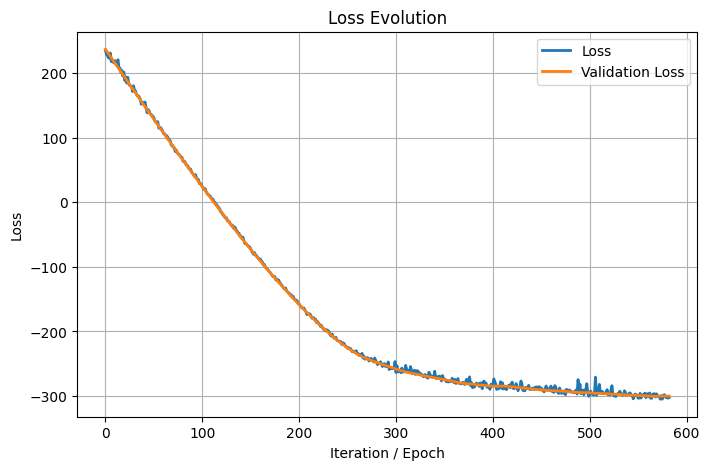

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.4288e+00,  1.2977e+00,  1.2368e+00,  1.3663e+00,  1.4090e+00,
         1.7220e+00,  1.4525e+00,  9.5177e-01,  1.6045e+00,  2.8143e+00,
         1.6411e+00,  1.6411e+00, -9.2975e+00,  1.1359e+00,  1.1385e+00,
         1.1862e+00,  1.1408e+00,  1.4890e+00,  1.2169e+00,  8.7594e-01,
         2.4312e+00,  3.2444e+00,  1.6411e+00,  1.6411e+00, -2.2881e-02,
         3.6370e-02,  3.4325e-02, -2.6466e-02,  3.8735e-02,  1.0561e-02,
         6.8537e-02,  4.9226e-02,  1.5730e-01,  5.4735e-02, -4.8349e-02,
        -1.5326e-01, -1.0812e-02,  2.5509e-01,  3.6218e-01,  4.5452e-01,
         2.1537e-01, -3.5139e-02,  8.7561e-02, -2.5684e-02, -5.4791e-01,
         5.0782e-01,  6.7657e-01,  2.7382e-01,  2.3167e-01,  3.9324e-01,
        -1.6072e-01, -1.1482e-01,  3.0880e-01, -4.3578e-02, -2.0755e-01,
        -5.1230e-01, -2.0489e-01,  2.3633e-01,  2.2817e-01,  3.5659e-02,
        -6.4779e-03,  4.2446e-02,  2.5179e-02,  1.3799e-02,  1.4803e-02,
         5.9199e-02, -1.1137e-02,  1.5556e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.1354
KLD Gaussian Train Data:  0.1238
KLD Copula   Train Data:  -0.0006
KLD GTM      Test  Data:  1.1274
KLD Gaussian Test  Data:  0.1099
KLD Copula   Test  Data:  0.0015


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

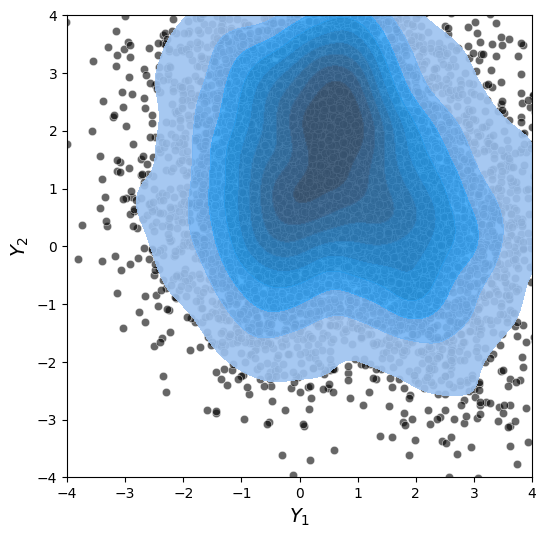

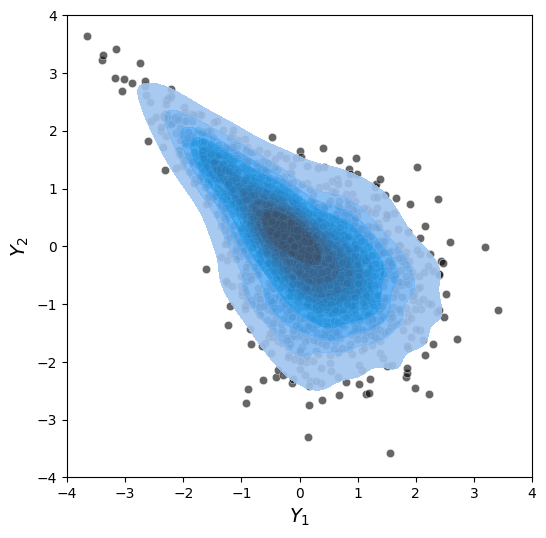

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


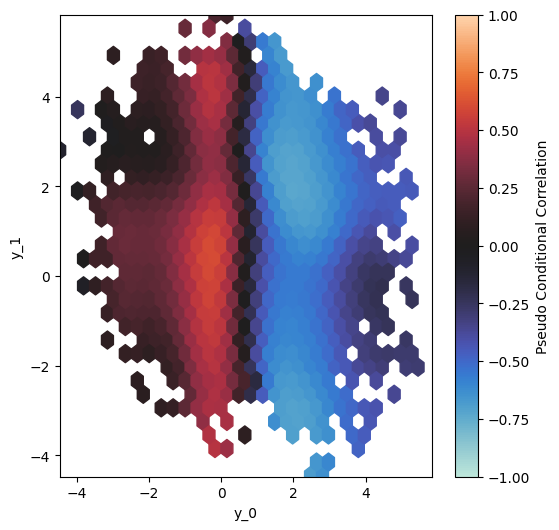

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


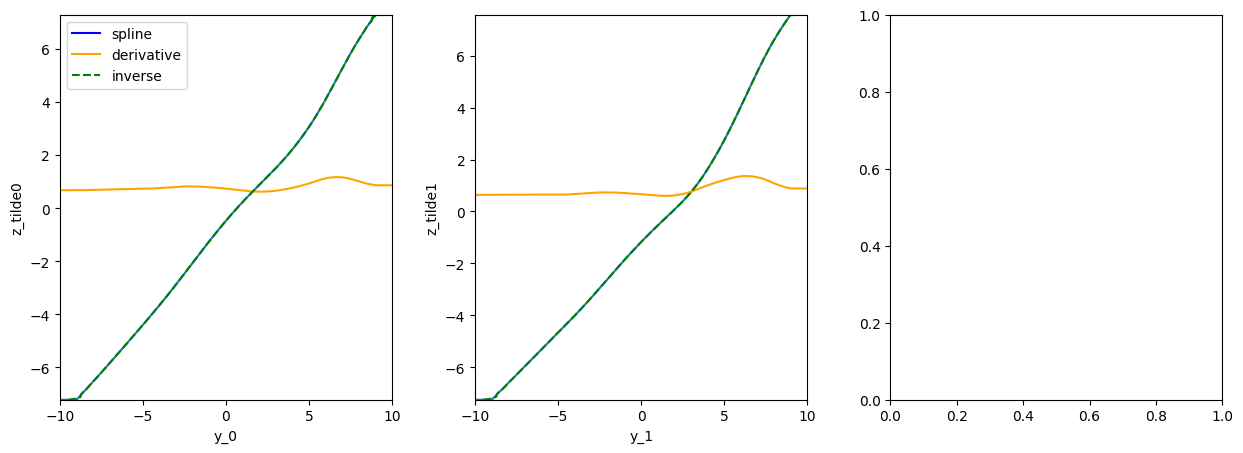

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


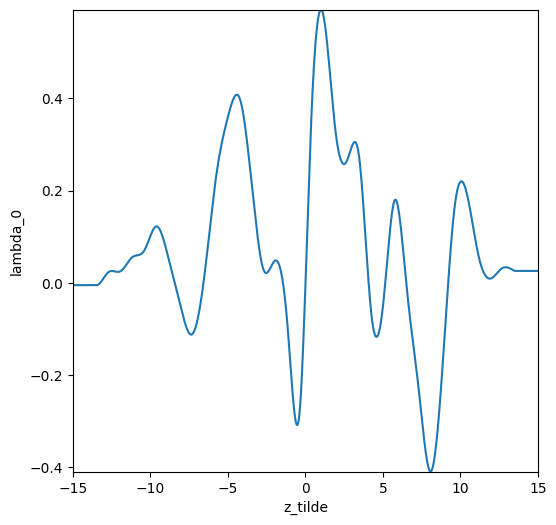

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


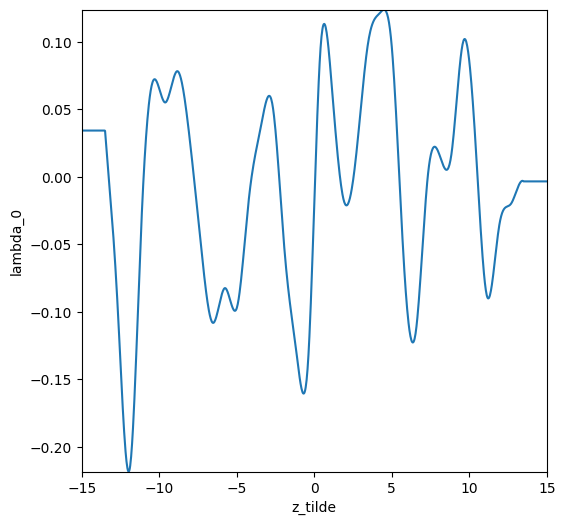

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


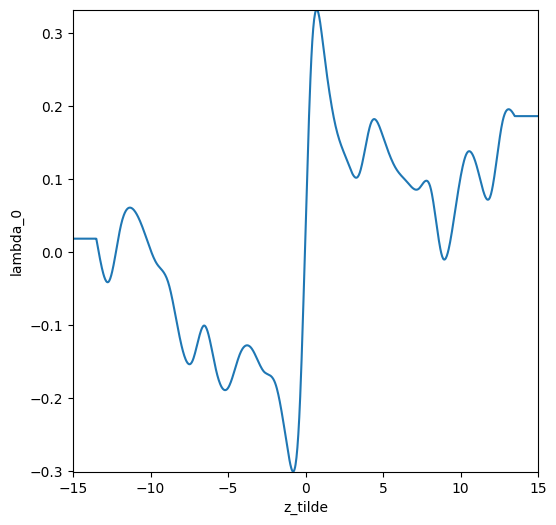

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)